<a href="https://colab.research.google.com/github/Foluwa/HDR_Group_8_Tech_Challenge/blob/main/notebooks/FOLU_HDRUK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=7debfd942f96a1e6b90e16f860726f5cf164ead699a2c410a2d009a03c7c496b
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zipfile import ZipFile
from scipy import stats
from lifelines import KaplanMeierFitter
import warnings

In [3]:
warnings.filterwarnings('ignore')
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 14)

# Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and unzip datasets

In [5]:
# Version 2
!cp "/content/drive/My Drive/simulacrum_v2.1.0.zip" .
!unzip simulacrum_v2.1.0.zip

Archive:  simulacrum_v2.1.0.zip
   creating: simulacrum_v2.1.0/
   creating: simulacrum_v2.1.0/Data/
  inflating: simulacrum_v2.1.0/Data/sim_av_gene.csv  
  inflating: simulacrum_v2.1.0/Data/sim_av_patient.csv  
  inflating: simulacrum_v2.1.0/Data/sim_av_tumour.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_combined.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_episode.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_exposure.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_prescription.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_cycle.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_drug_detail.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_outcome.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_regimen.csv  
   creating: simulacrum_v2.1.0/Documents/
  inflating: simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx  
  inflating: simulacrum_v2.1.0/Documents/Simulacrum_2_data_dictionaryVer2.1.0_2016-2019.xlsx  
  inflating: simulacrum_v2.1.0/LICENSE.txt  
 

In [6]:
# # Version 1
# !cp "/content/drive/My Drive/simulacrum_release_v1.2.0.2017.zip" .
# !unzip simulacrum_release_v1.2.0.2017.zip

## Load datasets

In [7]:
DATA_DIR   = "./simulacrum_v2.1.0/Data"
LOOKUP_XLS = "./simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx"

# Load Datasets

In [8]:
tumour   = pd.read_csv(f"{DATA_DIR}/sim_av_tumour.csv")
patient  = pd.read_csv(f"{DATA_DIR}/sim_av_patient.csv")
gene     = pd.read_csv(f"{DATA_DIR}/sim_av_gene.csv")
sact_reg = pd.read_csv(f"{DATA_DIR}/sim_sact_regimen.csv")
rtds_all = pd.read_csv(f"{DATA_DIR}/sim_rtds_combined.csv")

###  FILTER FOR C34 (LUNG CANCER)

In [9]:
lung_tumours = tumour[tumour["SITE_ICD10_O2_3CHAR"] == "C34"].copy()
lung_ids     = lung_tumours["PATIENTID"].unique()

lung_patients  = patient[patient["PATIENTID"].isin(lung_ids)].copy()
lung_genes     = gene[gene["PATIENTID"].isin(lung_ids)].copy()
lung_sact_reg  = sact_reg[sact_reg["ENCORE_PATIENT_ID"].isin(lung_ids)].copy()
lung_rtds      = rtds_all[rtds_all["PATIENTID"].isin(lung_ids)].copy()

### Merge into a dataframe

In [10]:
df_lung = (
    lung_patients
    .merge(lung_tumours.groupby("PATIENTID").first().reset_index(),
           on="PATIENTID", suffixes=("_pt", "_tum"))
    .merge(lung_sact_reg.groupby("ENCORE_PATIENT_ID").first().reset_index()
                       .rename(columns={"ENCORE_PATIENT_ID":"PATIENTID"}),
           on="PATIENTID", how="left")
    .merge(lung_rtds.groupby("PATIENTID").first().reset_index(),
           on="PATIENTID", how="left", suffixes=("", "_rt"))
    .merge(lung_genes.groupby("PATIENTID")["GENE"].nunique()
                      .reset_index()
                      .rename(columns={"GENE":"num_genes_tested"}),
           on="PATIENTID", how="left")
)
print("df_lung shape after core merge:", df_lung.shape)

df_lung shape after core merge: (154885, 80)


### Merge lookups

In [11]:
xls = pd.ExcelFile(LOOKUP_XLS)
gender_lkp    = pd.read_excel(xls,"z_gender"   ).rename(columns={"Code":"GENDER",    "Description":"gender_label"})
ethnicity_lkp = pd.read_excel(xls,"z_ethnicity").rename(columns={"Code":"ETHNICITY", "Description":"ethnicity_label"})
stage_lkp     = pd.read_excel(xls,"z_stage"    ).rename(columns={"Code":"STAGE_BEST","Description":"stage_label"})

In [12]:
def pick(colnames, *candidates):
    for c in candidates:
        if c in colnames: return c
    raise KeyError(f"None of {candidates} in columns")

In [13]:
gender_key    = pick(df_lung.columns, "GENDER_pt",    "GENDER")
ethnicity_key = pick(df_lung.columns, "ETHNICITY_pt", "ETHNICITY")

In [14]:
df_lung = (
    df_lung
      .merge(gender_lkp,    left_on=gender_key,    right_on="GENDER",    how="left")
      .merge(ethnicity_lkp, left_on=ethnicity_key, right_on="ETHNICITY", how="left")
      .merge(stage_lkp,     on="STAGE_BEST",       how="left")
      .drop(columns=["GENDER", "ETHNICITY"], errors="ignore")
)

df_lung['DiagDate'] = pd.to_datetime(df_lung['DIAGNOSISDATEBEST'])
df_lung['EndDate']  = pd.to_datetime(df_lung['VITALSTATUSDATE'])

df_lung['followup_days'] = (
    df_lung['EndDate'] - df_lung['DiagDate']
).dt.days.clip(lower=0)

df_lung['event_observed'] = (df_lung['VITALSTATUS'] == 'D').astype(int)
df_lung['received_sact'] = df_lung['MERGED_REGIMEN_ID'].notna()

In [15]:
if "Stage_Group" not in df_lung.columns:
    df_lung["Stage_Group"] = df_lung.apply(
        lambda r: r["stage_label"] if pd.notnull(r["stage_label"])
        else f"Stage {str(r['STAGE_BEST'])[0]}",
        axis=1
    )

In [16]:
df_lung.head()

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4


In [17]:
df_lung.head()

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4


In [18]:
df_lung

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154880,250001673,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Any other White background,Insufficient information,2018-11-15,2022-07-05,1328.0,0,False,Insufficient information
154881,250001811,1,NaN,NaN,NaN,NaN,NaN,NaN,D,2018-11-29,...,3.0,Male,White British,NaN,2017-07-22,2018-11-29,495.0,1,True,Stage 1
154882,250001923,1,C099,NaN,NaN,NaN,C61,1,D,2021-03-20,...,NaN,Male,White British,Stage 1,2019-10-18,2021-03-20,519.0,1,True,Stage 1
154883,250002138,2,C679,NaN,NaN,NaN,C679,2,D,2022-08-12,...,1.0,Female,White British,Stage 4,2019-09-11,2022-08-12,1066.0,1,False,Stage 4


In [19]:
df_lung.describe()

,PATIENTID,GENDER_pt,LINKNUMBER,TUMOURID,GENDER_tum,MORPH_ICD10_O2,MORPH_ICDO3REV2011,BEHAVIOUR_ICD10_O2,BEHAVIOUR_ICDO3REV2011,AGE,...,RTPRESCRIBEDFRACTIONS,RTACTUALDOSE,RTACTUALFRACTIONS,RADIOTHERAPYEPISODEID,RADIOTHERAPYBEAMENERGY,num_genes_tested,DiagDate,EndDate,followup_days,event_observed
count,1.548850e+05,154885.000000,1.548850e+05,1.548850e+05,154885.000000,154885.000000,154882.000000,154885.000000,154885.000000,154885.000000,...,52365.000000,51967.000000,52295.000000,5.336500e+04,53356.000000,43039.000000,154885,154844,154844.000000,154885.000000
mean,7.146299e+07,1.465836,1.009361e+08,1.099888e+07,1.465836,8094.835484,8100.566128,3.001466,3.001123,72.294147,...,11.224234,26.609538,10.691787,1.498649e+06,6.125920,1.745324,2017-12-29 00:44:26.442844672,2019-08-18 09:29:44.702022656,597.393641,0.789773
min,1.017521e+07,1.000000,1.000000e+08,1.000000e+07,1.000000,8000.000000,8000.000000,0.000000,0.000000,0.000000,...,1.000000,-45.962824,1.000000,1.000013e+06,0.000000,1.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,0.000000,0.000000
25%,6.003337e+07,1.000000,1.004684e+08,1.049723e+07,1.000000,8010.000000,8010.000000,3.000000,3.000000,66.000000,...,3.000000,10.000000,2.000000,1.244486e+06,6.000000,1.000000,2016-12-28 00:00:00,2018-01-09 00:00:00,61.000000,1.000000
50%,6.007209e+07,1.000000,1.009364e+08,1.099816e+07,1.000000,8070.000000,8070.000000,3.000000,3.000000,73.000000,...,5.000000,20.000000,5.000000,1.500122e+06,6.000000,2.000000,2017-12-28 00:00:00,2019-05-31 00:00:00,282.000000,1.000000
75%,1.000085e+08,2.000000,1.014033e+08,1.149920e+07,2.000000,8140.000000,8140.000000,3.000000,3.000000,80.000000,...,20.000000,39.000000,20.000000,1.749019e+06,6.000000,2.000000,2018-12-28 00:00:00,2021-07-18 00:00:00,1054.000000,1.000000
max,2.500025e+08,2.000000,1.018716e+08,1.200000e+07,2.000000,9989.000000,9989.000000,9.000000,9.000000,107.000000,...,60.000000,1118.000000,72.000000,1.999997e+06,380.000000,18.000000,2019-12-31 00:00:00,2022-11-19 00:00:00,2377.000000,1.000000
std,2.172299e+07,0.498833,5.401904e+05,5.775011e+05,0.498833,132.318343,146.940261,0.130425,0.122119,11.011590,...,10.168607,19.518956,10.199820,2.895555e+05,5.607558,0.829729,NaN,NaN,661.485833,0.407471


In [20]:
assert df_lung["SITE_ICD10_O2_3CHAR"].unique().tolist() == ["C34"]
assert df_lung["PATIENTID"].isna().sum() == 0

# Exploratory Data Analysis

### Data Type Distribution

In [21]:
def plot_data_type_distribution(df):
    dtype_counts = df.dtypes.value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(dtype_counts.values, labels=dtype_counts.index.astype(str), autopct='%1.1f%%')
    plt.title('Data Types Distribution')
    plt.tight_layout()
    plt.show()

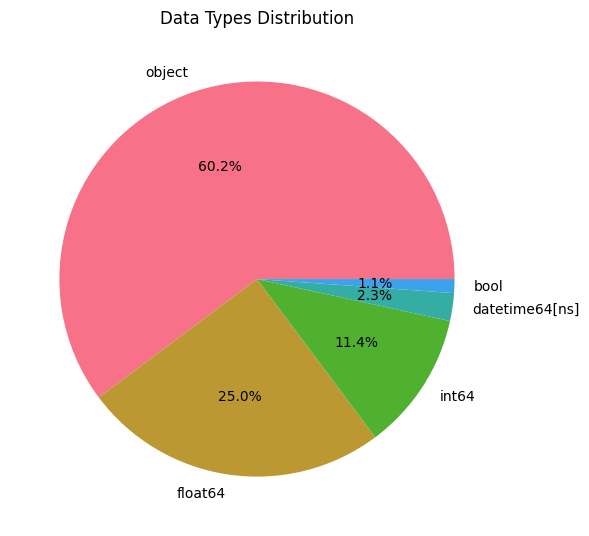

In [22]:
plot_data_type_distribution(df_lung)

### Missing Values

In [23]:
def plot_missing_data_bar(df):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    if not missing_counts.empty:
        missing_counts.plot(kind='bar', figsize=(28, 10))
        plt.title('Missing Values by Column')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values in dataset.")

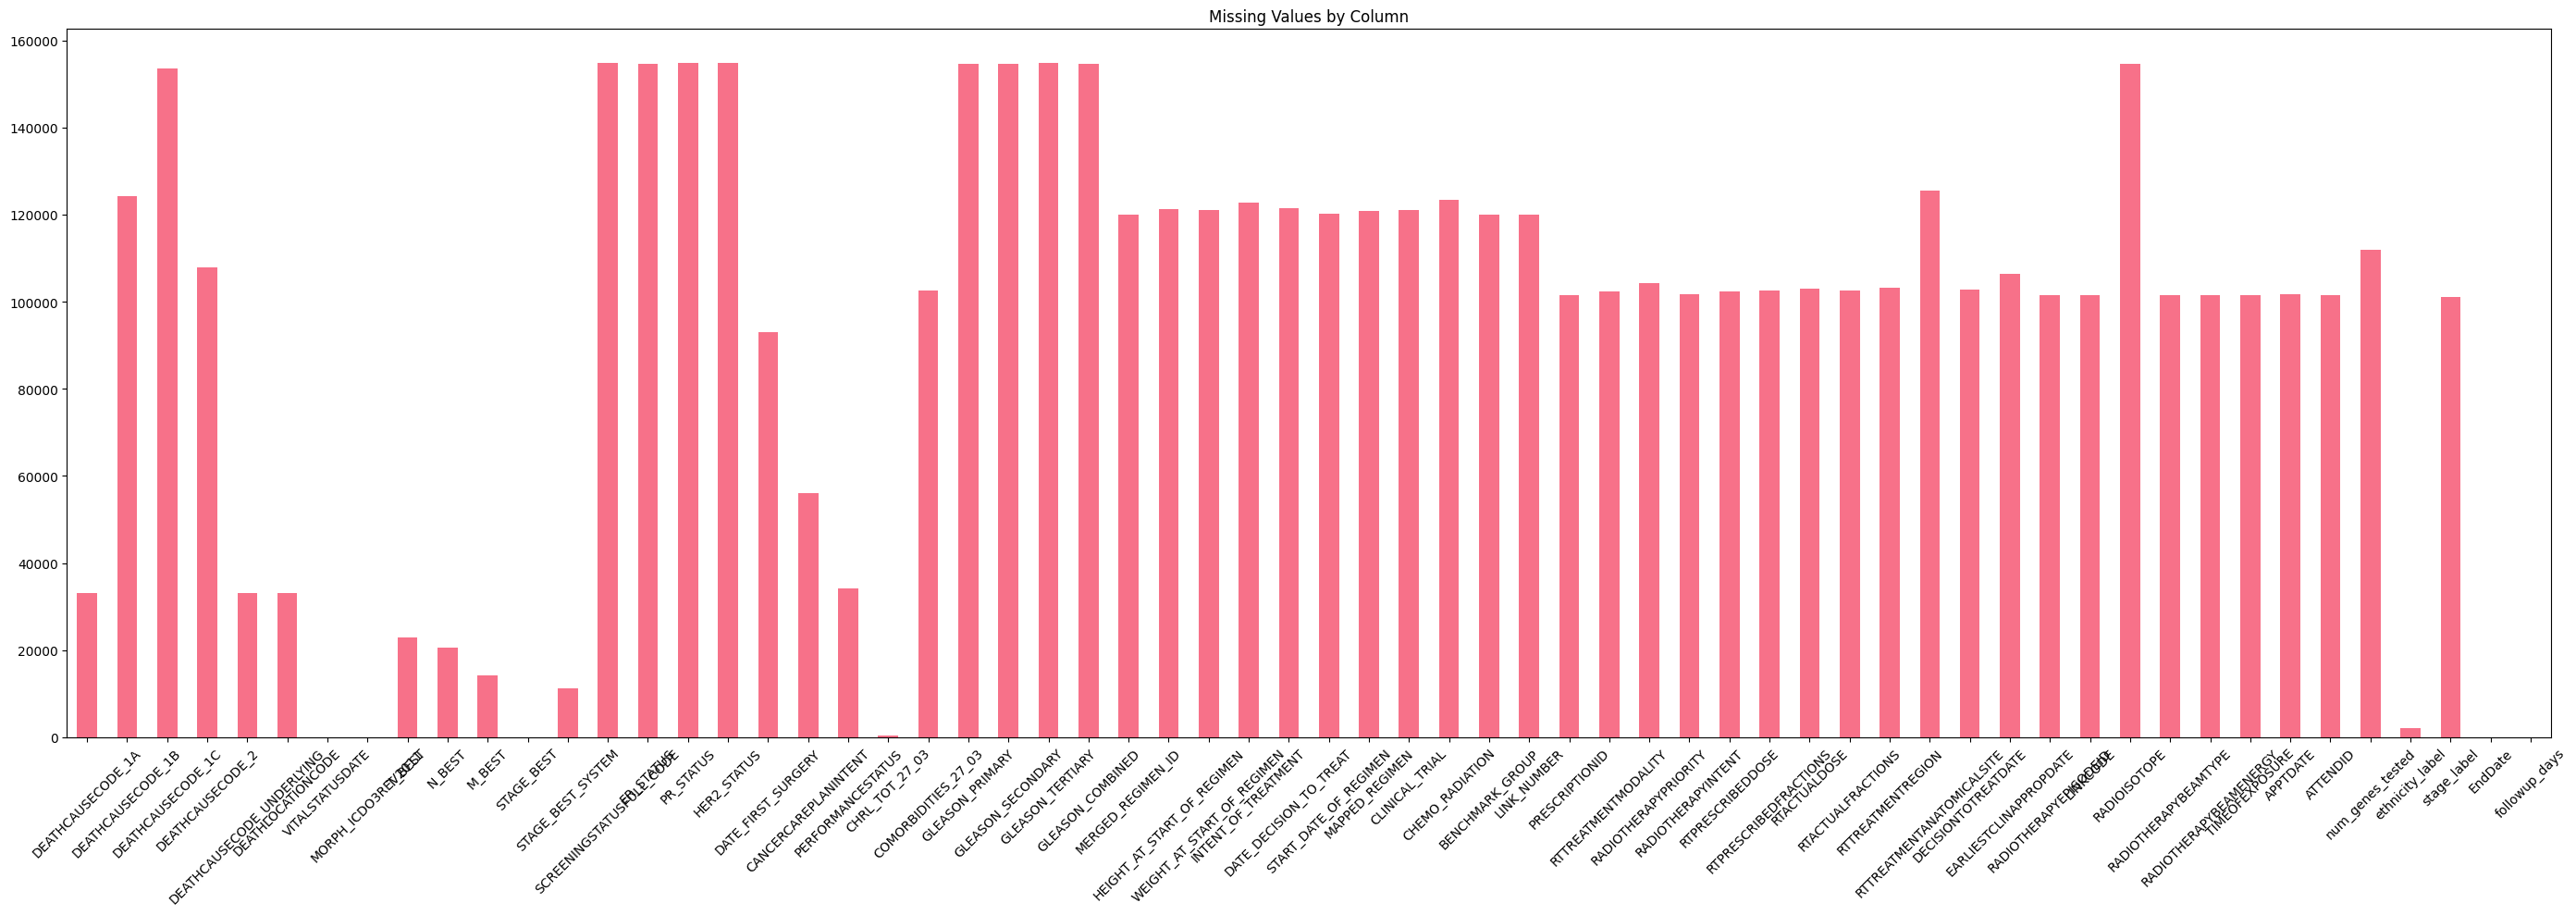

In [24]:
plot_missing_data_bar(df_lung)

### Correlation Matrix

In [25]:
df_lung.head()

,PATIENTID,GENDER_pt,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,...,num_genes_tested,gender_label,ethnicity_label,stage_label,DiagDate,EndDate,followup_days,event_observed,received_sact,Stage_Group
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,1.0,Male,NaN,NaN,2019-09-12,2022-07-05,1027.0,0,True,Stage 3
1,10175273,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-11-04,2022-07-05,974.0,0,False,Stage 1
2,10175282,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,2.0,Male,Not stated,NaN,2017-07-08,2022-07-05,1823.0,0,True,Stage 3
3,10175292,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,Not stated,NaN,2018-07-29,2022-07-05,1437.0,0,True,Stage 4
4,10175333,1,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,...,NaN,Male,White British,NaN,2019-09-21,2022-07-05,1018.0,0,False,Stage 4


In [26]:
def plot_correlation_heatmap(df, exclude=None, min_unique=2):
    exclude = exclude or []

    # Keep only numeric columns and drop the excluded list
    num_df = (
        df.drop(columns=exclude, errors="ignore")
          .select_dtypes(include=[np.number])
    )

    # Drop constant / near-constant columns
    num_df = num_df.loc[:, num_df.nunique() >= min_unique]

    if num_df.shape[1] < 2:
        print("Not enough numeric columns with variance for a correlation matrix.")
        return

    corr = num_df.corr()

    # Optional: show only lower triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(20, 16))
    sns.heatmap(
        corr, mask=mask, cmap='coolwarm', center=0,
        vmin=-1, vmax=1, linewidths=.5, annot=True, fmt=".2f"
    )
    plt.title("Correlation Matrix (variance-filtered)")
    plt.tight_layout()
    plt.show()


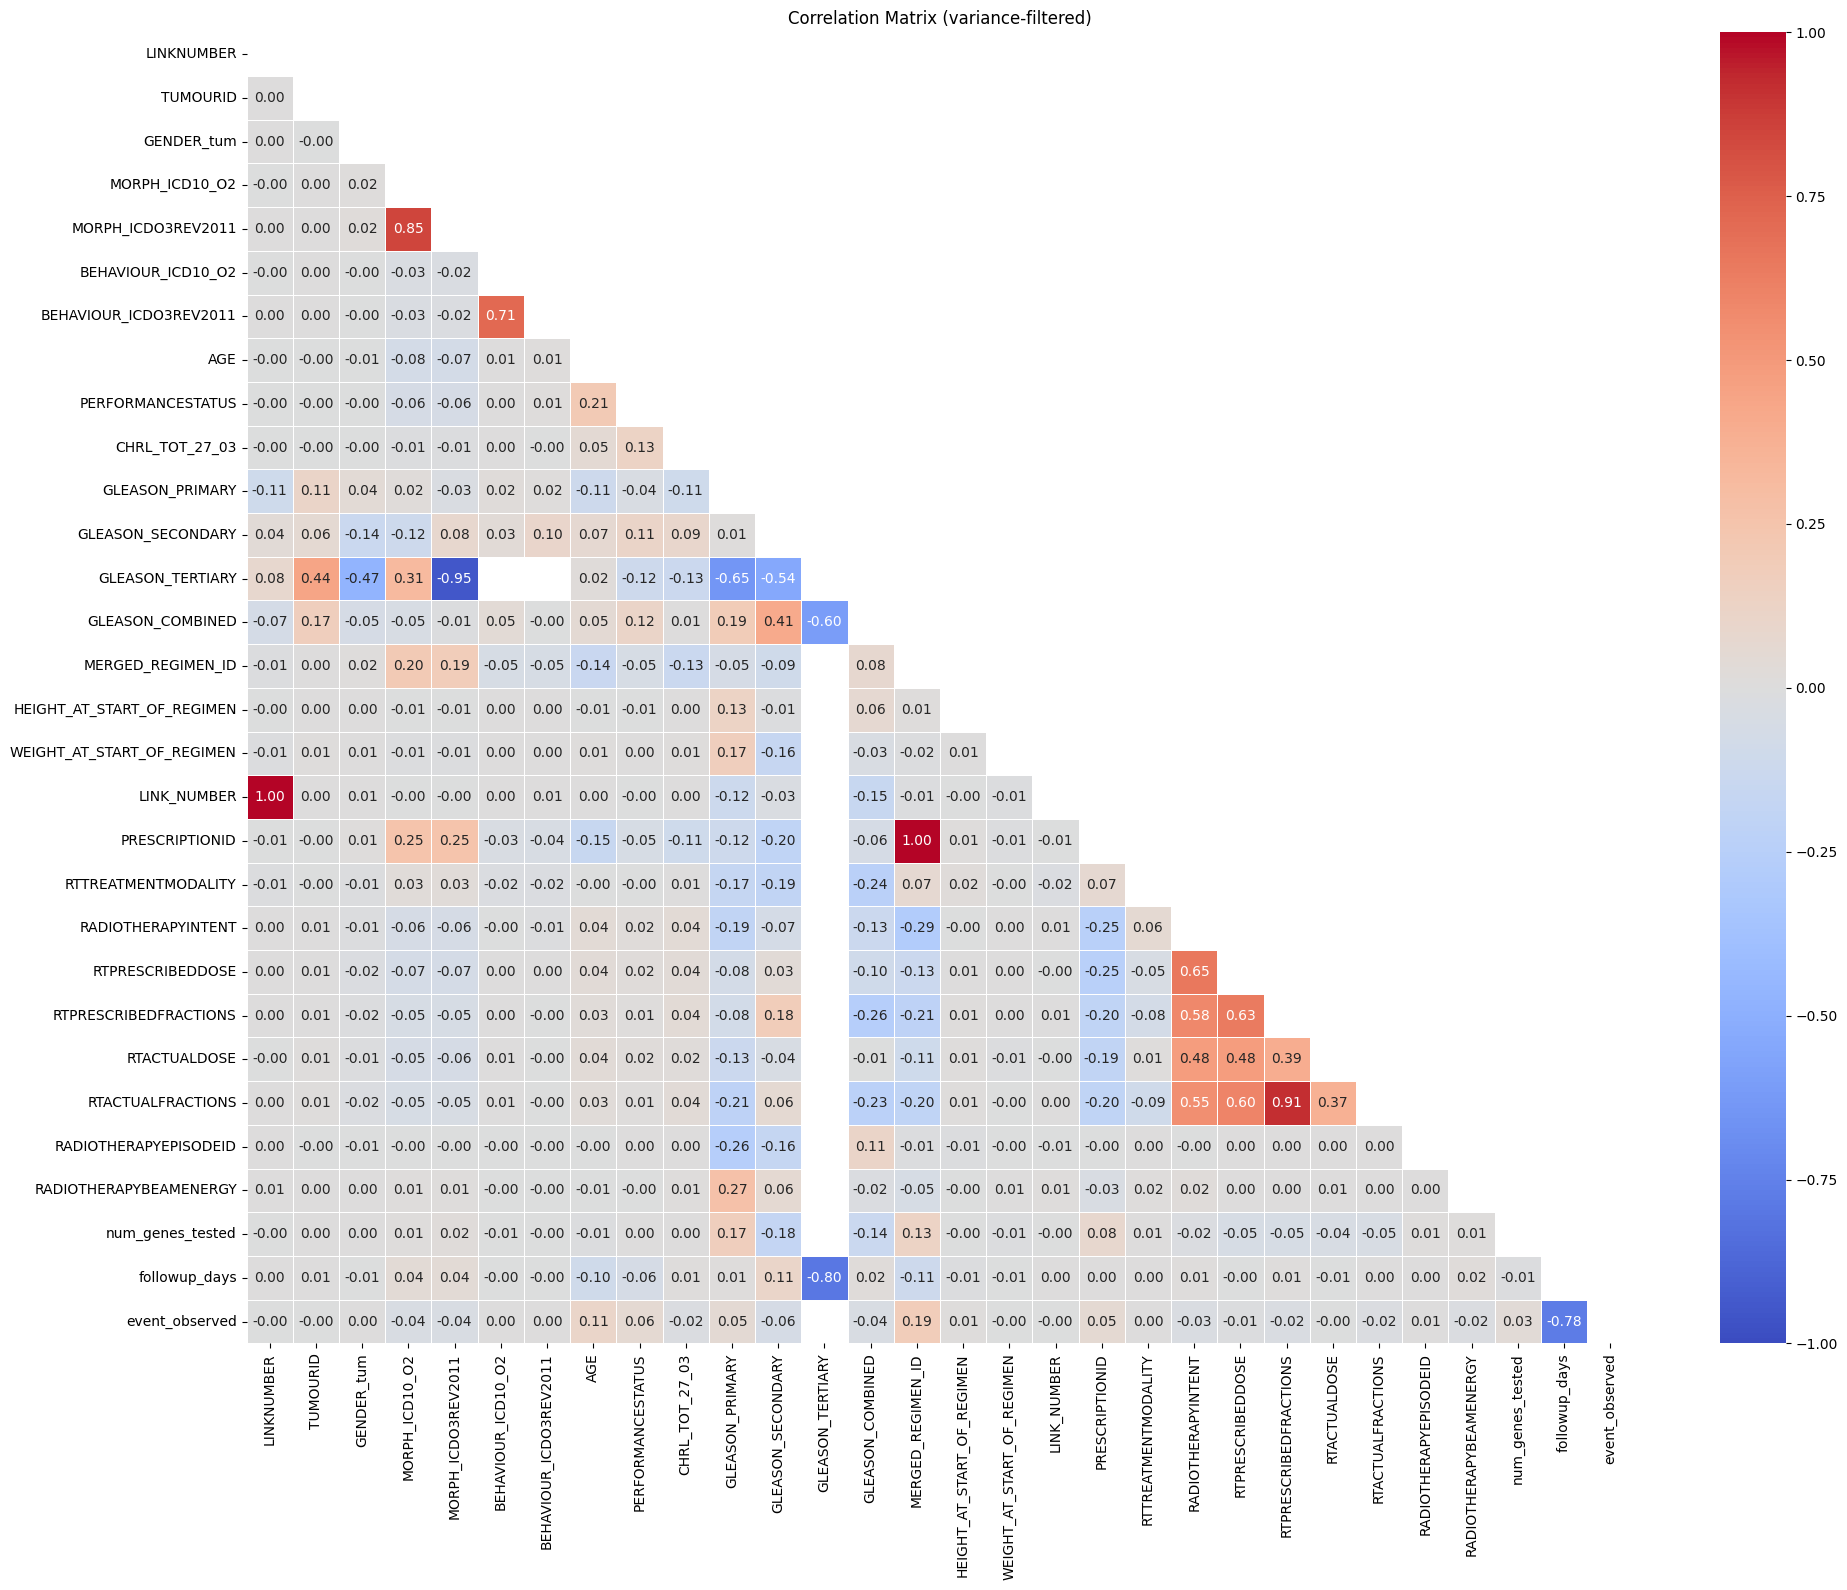

In [27]:
plot_correlation_heatmap(df_lung,exclude=["PATIENTID", "GENDER_pt"])

### Descriptive Stats

In [62]:
def descriptive_stats(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        display(df[numeric_cols].describe())

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        for col in categorical_cols[:5]:
            print(df[col].value_counts().head())

In [63]:
descriptive_stats(df_lung)

,PATIENTID,GENDER_pt,LINKNUMBER,TUMOURID,GENDER_tum,MORPH_ICD10_O2,MORPH_ICDO3REV2011,BEHAVIOUR_ICD10_O2,BEHAVIOUR_ICDO3REV2011,AGE,...,RADIOTHERAPYINTENT,RTPRESCRIBEDDOSE,RTPRESCRIBEDFRACTIONS,RTACTUALDOSE,RTACTUALFRACTIONS,RADIOTHERAPYEPISODEID,RADIOTHERAPYBEAMENERGY,num_genes_tested,followup_days,event_observed
count,1.548850e+05,154885.000000,1.548850e+05,1.548850e+05,154885.000000,154885.000000,154882.000000,154885.000000,154885.000000,154885.000000,...,53141.000000,52549.000000,52365.000000,51967.000000,52295.000000,5.336500e+04,53356.000000,43039.000000,154844.000000,154885.000000
mean,7.146299e+07,1.465836,1.009361e+08,1.099888e+07,1.465836,8094.835484,8100.566128,3.001466,3.001123,72.294147,...,1.586289,35.873432,11.224234,26.609538,10.691787,1.498649e+06,6.125920,1.745324,597.393641,0.789773
std,2.172299e+07,0.498833,5.401904e+05,5.775011e+05,0.498833,132.318343,146.940261,0.130425,0.122119,11.011590,...,0.509185,23.728501,10.168607,19.518956,10.199820,2.895555e+05,5.607558,0.829729,661.485833,0.407471
min,1.017521e+07,1.000000,1.000000e+08,1.000000e+07,1.000000,8000.000000,8000.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,-45.962824,1.000000,1.000013e+06,0.000000,1.000000,0.000000,0.000000
25%,6.003337e+07,1.000000,1.004684e+08,1.049723e+07,1.000000,8010.000000,8010.000000,3.000000,3.000000,66.000000,...,1.000000,20.000000,3.000000,10.000000,2.000000,1.244486e+06,6.000000,1.000000,61.000000,1.000000
50%,6.007209e+07,1.000000,1.009364e+08,1.099816e+07,1.000000,8070.000000,8070.000000,3.000000,3.000000,73.000000,...,2.000000,36.000000,5.000000,20.000000,5.000000,1.500122e+06,6.000000,2.000000,282.000000,1.000000
75%,1.000085e+08,2.000000,1.014033e+08,1.149920e+07,2.000000,8140.000000,8140.000000,3.000000,3.000000,80.000000,...,2.000000,55.000000,20.000000,39.000000,20.000000,1.749019e+06,6.000000,2.000000,1054.000000,1.000000
max,2.500025e+08,2.000000,1.018716e+08,1.200000e+07,2.000000,9989.000000,9989.000000,9.000000,9.000000,107.000000,...,3.000000,2200.000000,60.000000,1118.000000,72.000000,1.999997e+06,380.000000,18.000000,2377.000000,1.000000


DEATHCAUSECODE_1A
C349    70867
J189     8078
J180     3929
C798     3559
J22      1654
Name: count, dtype: int64
DEATHCAUSECODE_1B
C349    15501
J449     1549
J189      765
I259      390
I251      347
Name: count, dtype: int64
DEATHCAUSECODE_1C
C349    461
F179     60
J449     52
I259     38
J189     23
Name: count, dtype: int64
DEATHCAUSECODE_2
J449    6750
C349    3466
I259    1489
I10      678
E119     632
Name: count, dtype: int64
DEATHCAUSECODE_UNDERLYING
C349    99129
C809     1362
J440     1273
U071     1086
J449     1085
Name: count, dtype: int64


In [30]:
assert 'PATIENTID' in df_lung.columns, "df_lung must have PATIENTID"
print("df_lung rows:", len(df_lung))
print("columns:", df_lung.columns.tolist()[:12], "...")

df_lung rows: 154885
columns: ['PATIENTID', 'GENDER_pt', 'DEATHCAUSECODE_1A', 'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2', 'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS', 'VITALSTATUSDATE', 'LINKNUMBER', 'TUMOURID'] ...


In [31]:
for expected in ['gender_label', 'ethnicity_label', 'stage_label']:
    if expected not in df_lung.columns:
        print(f"⚠️  Warning: {expected} missing – check earlier merge step")

# Simplify stage if Stage_Group not yet created
if 'Stage_Group' not in df_lung.columns:
    def simplify_stage(code, label):
        return label if pd.notnull(label) else f"Stage {str(code)[0]}"
    df_lung['Stage_Group'] = df_lung.apply(
        lambda row: simplify_stage(row['STAGE_BEST'], row.get('stage_label')),
        axis=1
    )

# v2

In [32]:
df_surv = df_lung.copy()

df_surv['DiagDate'] = pd.to_datetime(df_surv['DIAGNOSISDATEBEST'])
df_surv['EndDate']  = pd.to_datetime(df_surv['VITALSTATUSDATE'])
df_surv['followup_days'] = (df_surv['EndDate'] - df_surv['DiagDate']).dt.days.clip(lower=0)
df_surv['event_observed'] = (df_surv['VITALSTATUS'] == 'D').astype(int)

df_surv = df_surv[df_surv['followup_days'].notna() & (df_surv['followup_days'] >= 0)]

### Demographic Plots

In [33]:
def plot_counts(data, column, title, xlabel):
    sns.countplot(data=data, x=column, order=data[column].value_counts().index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

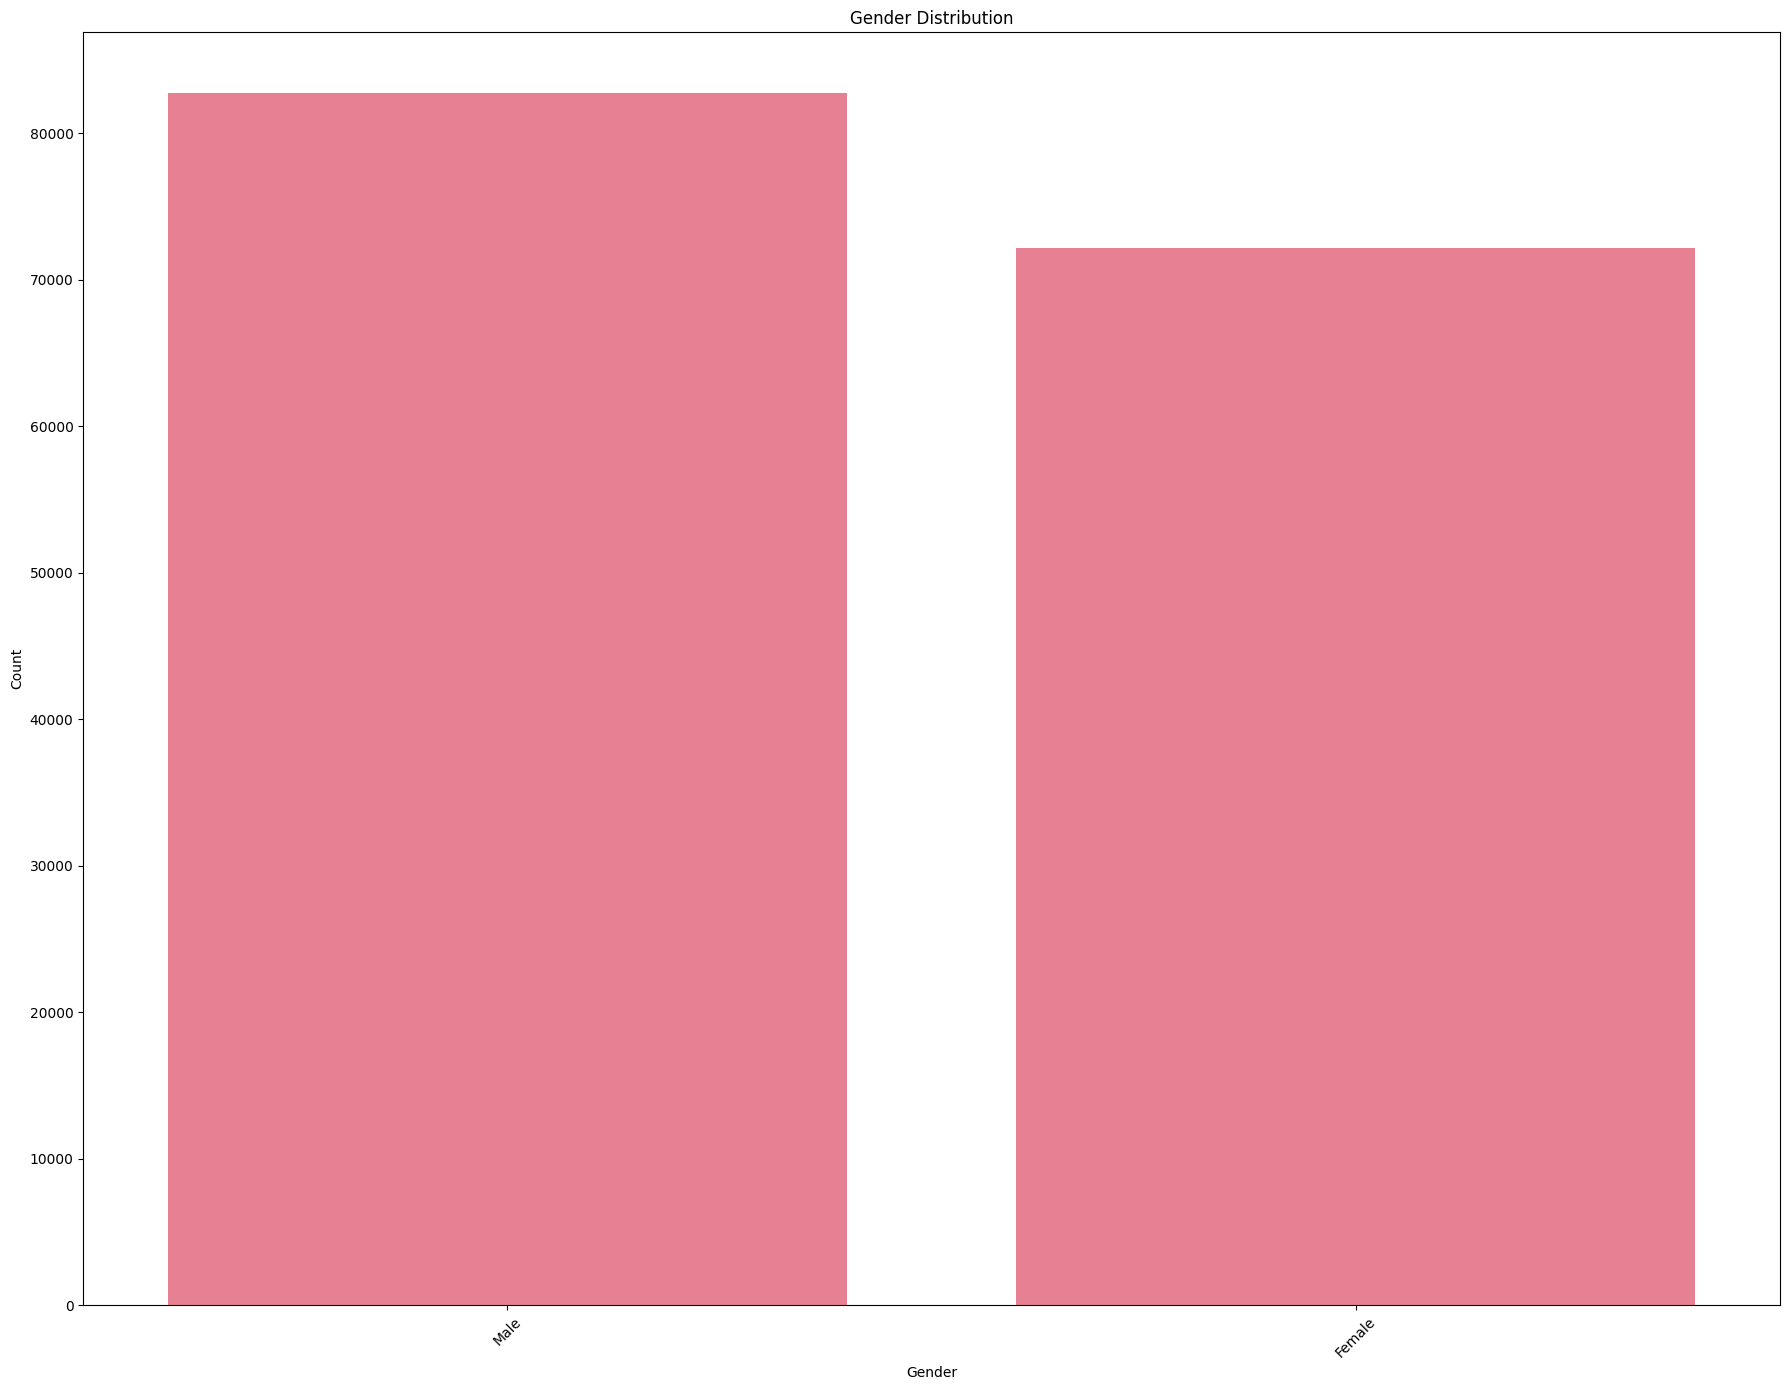

In [34]:
plot_counts(df_lung, "gender_label", "Gender Distribution", "Gender")

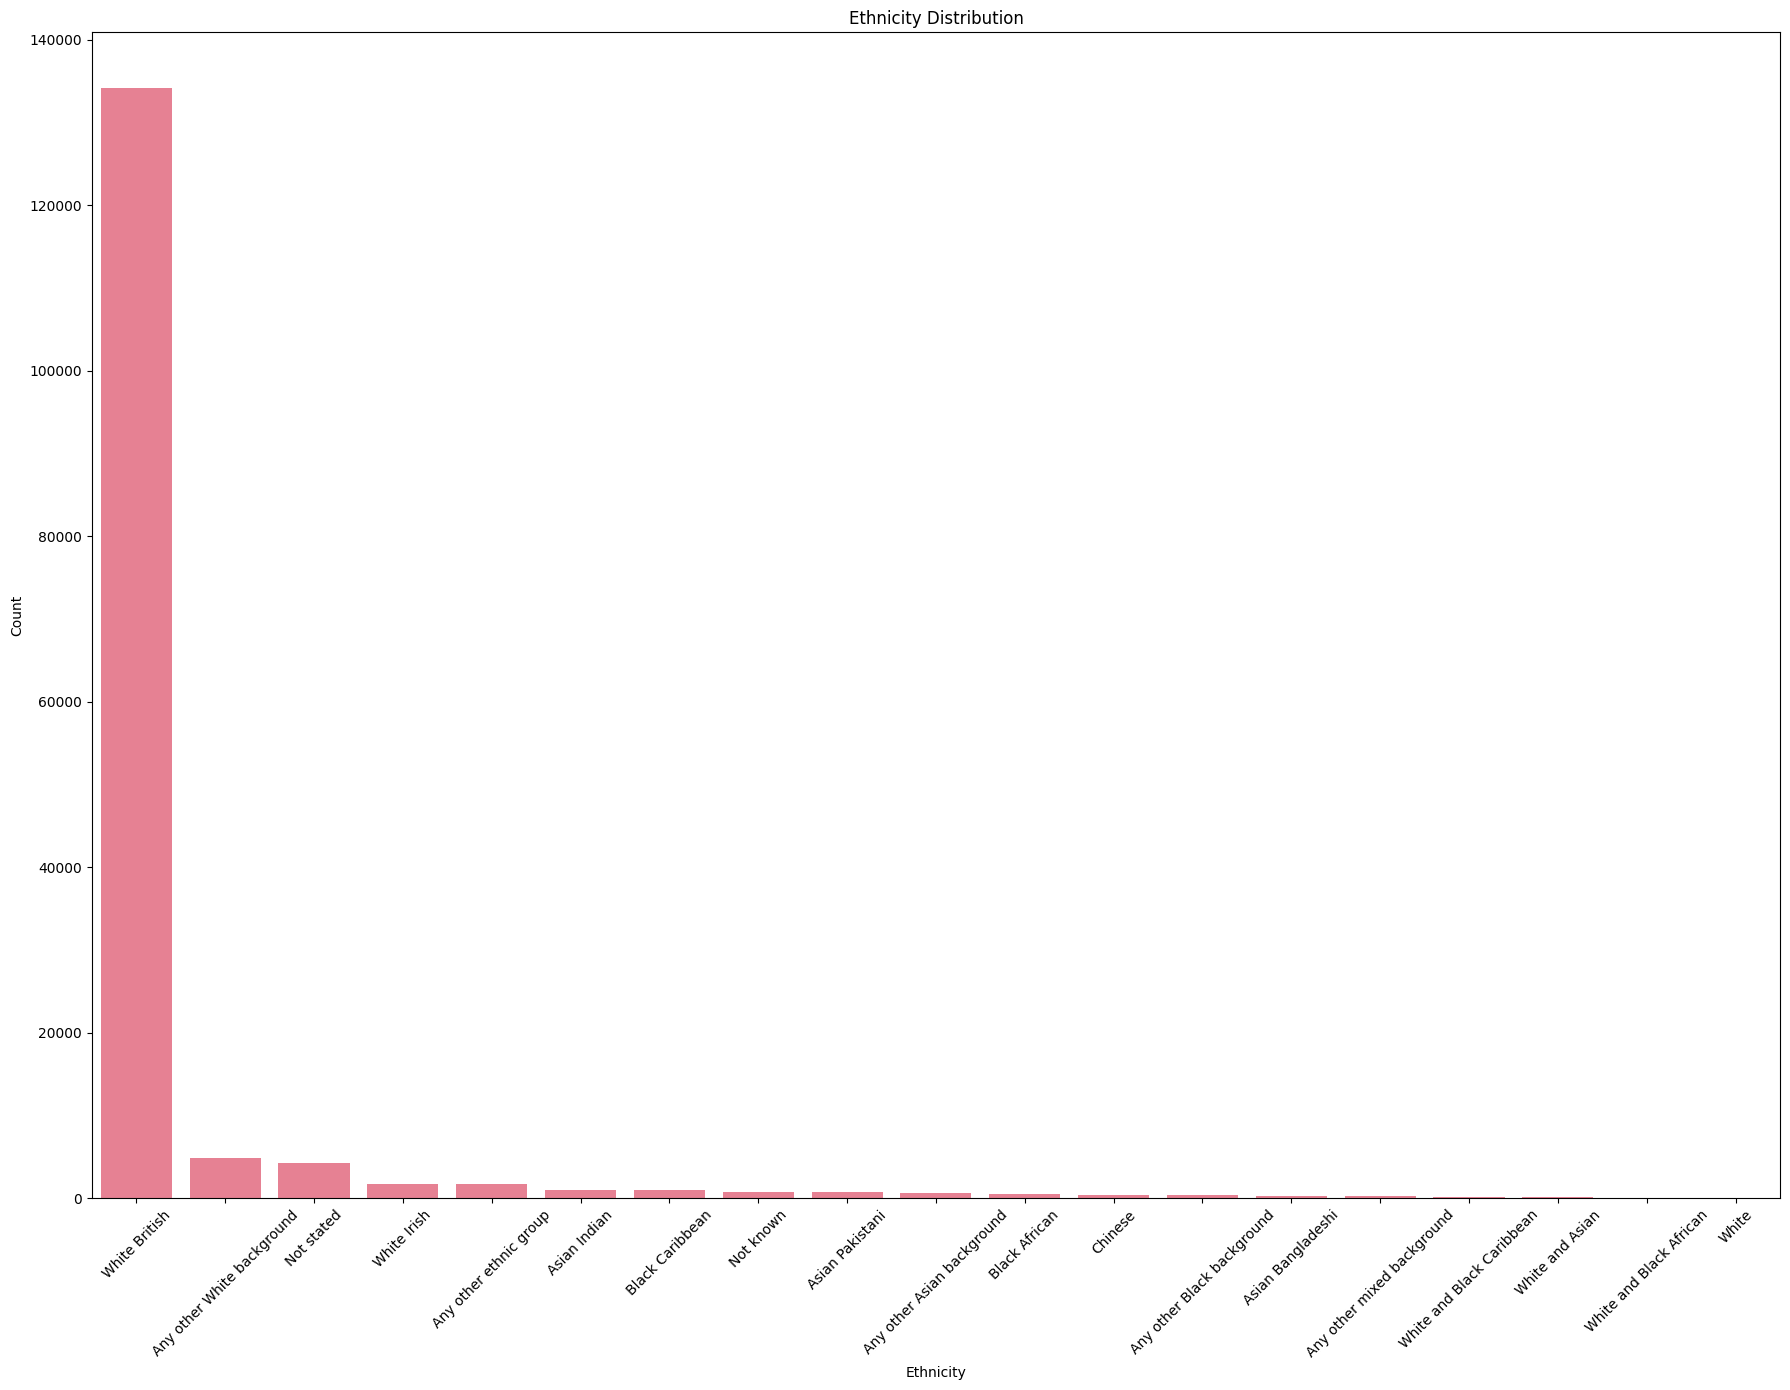

In [35]:
plot_counts(df_lung, "ethnicity_label", "Ethnicity Distribution", "Ethnicity")

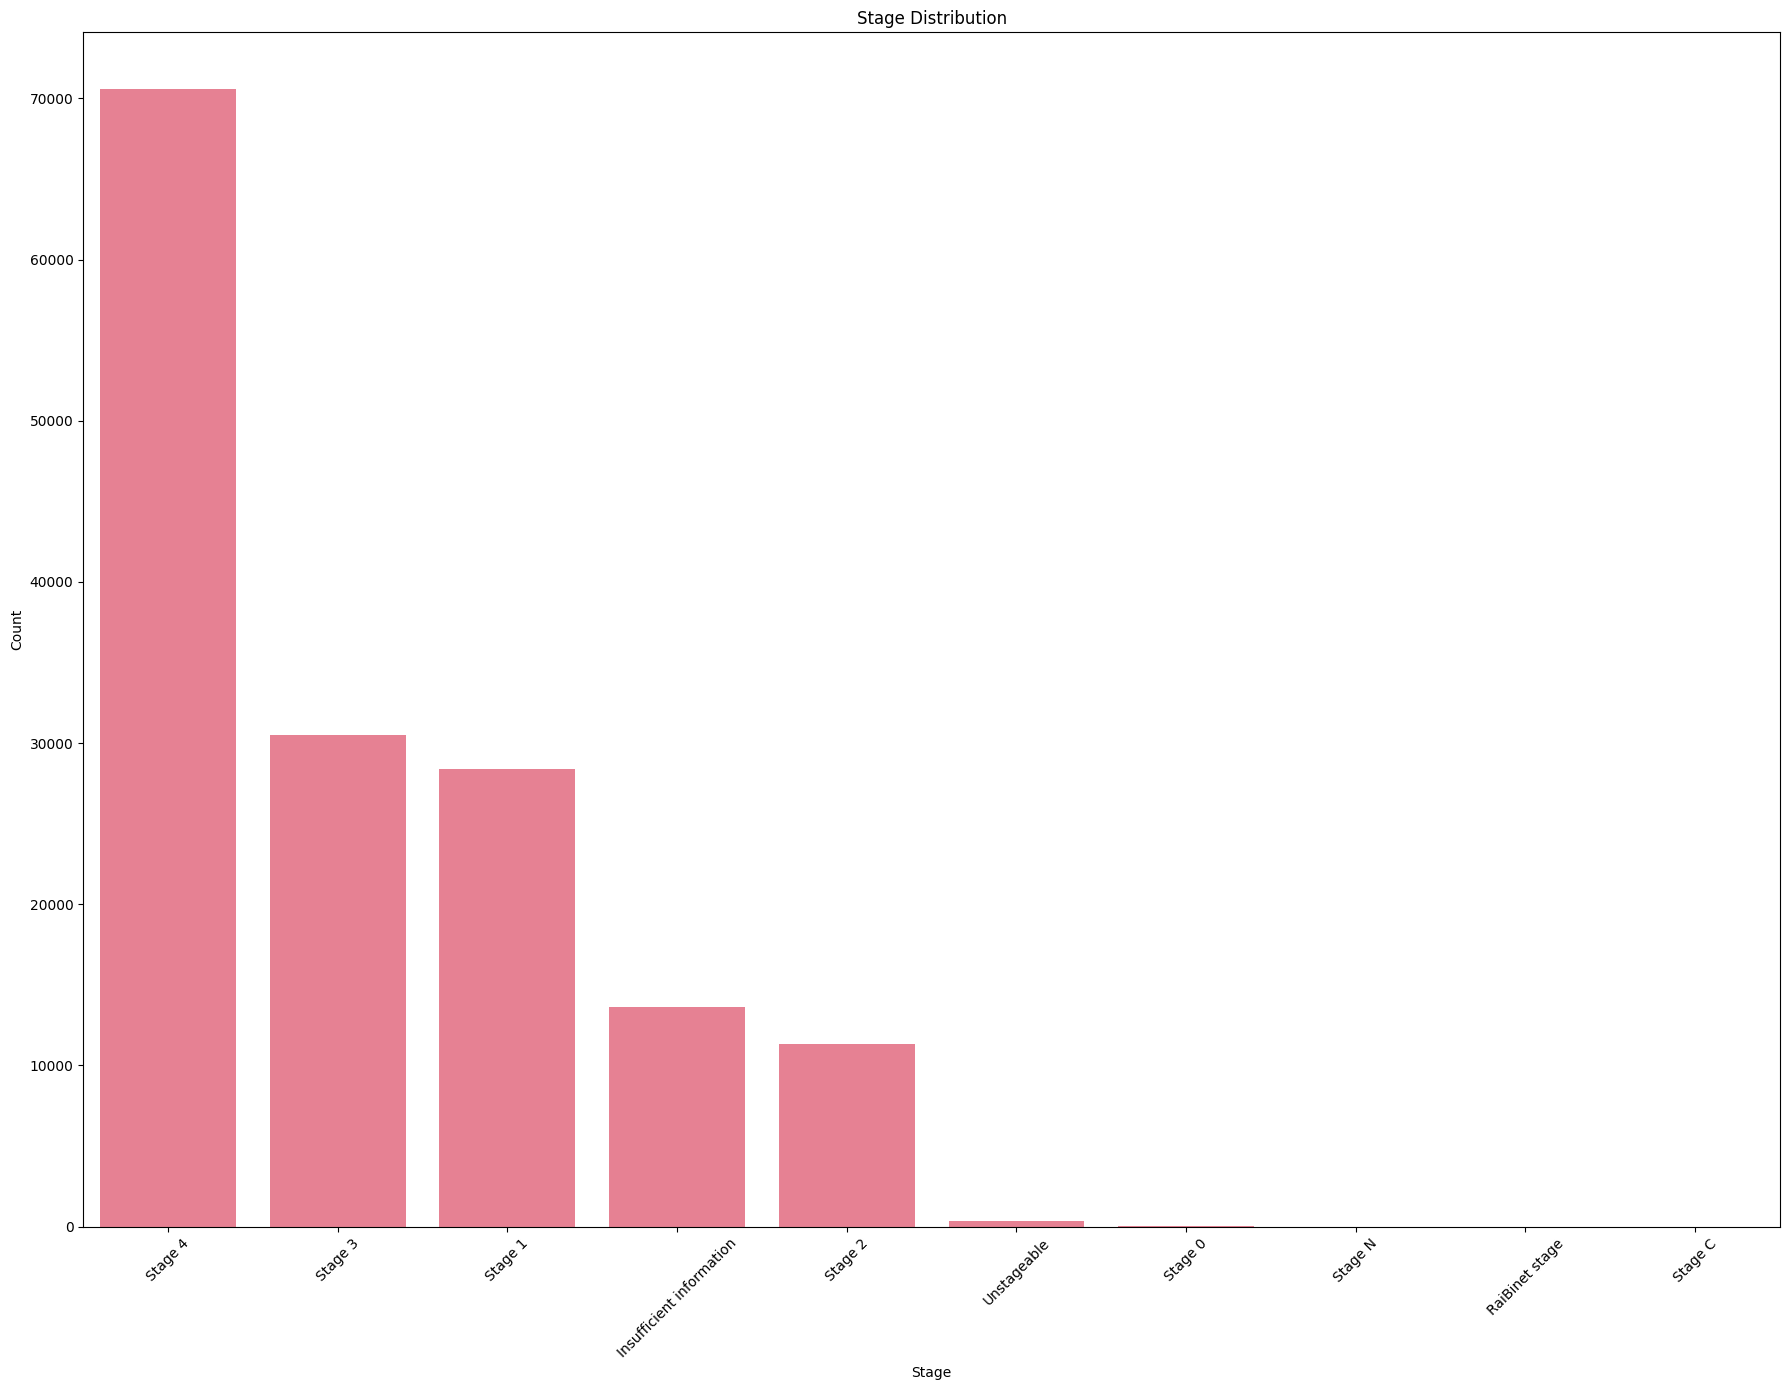

In [36]:
plot_counts(df_lung, "Stage_Group", "Stage Distribution", "Stage")

### Age Distribution at Diagnosis

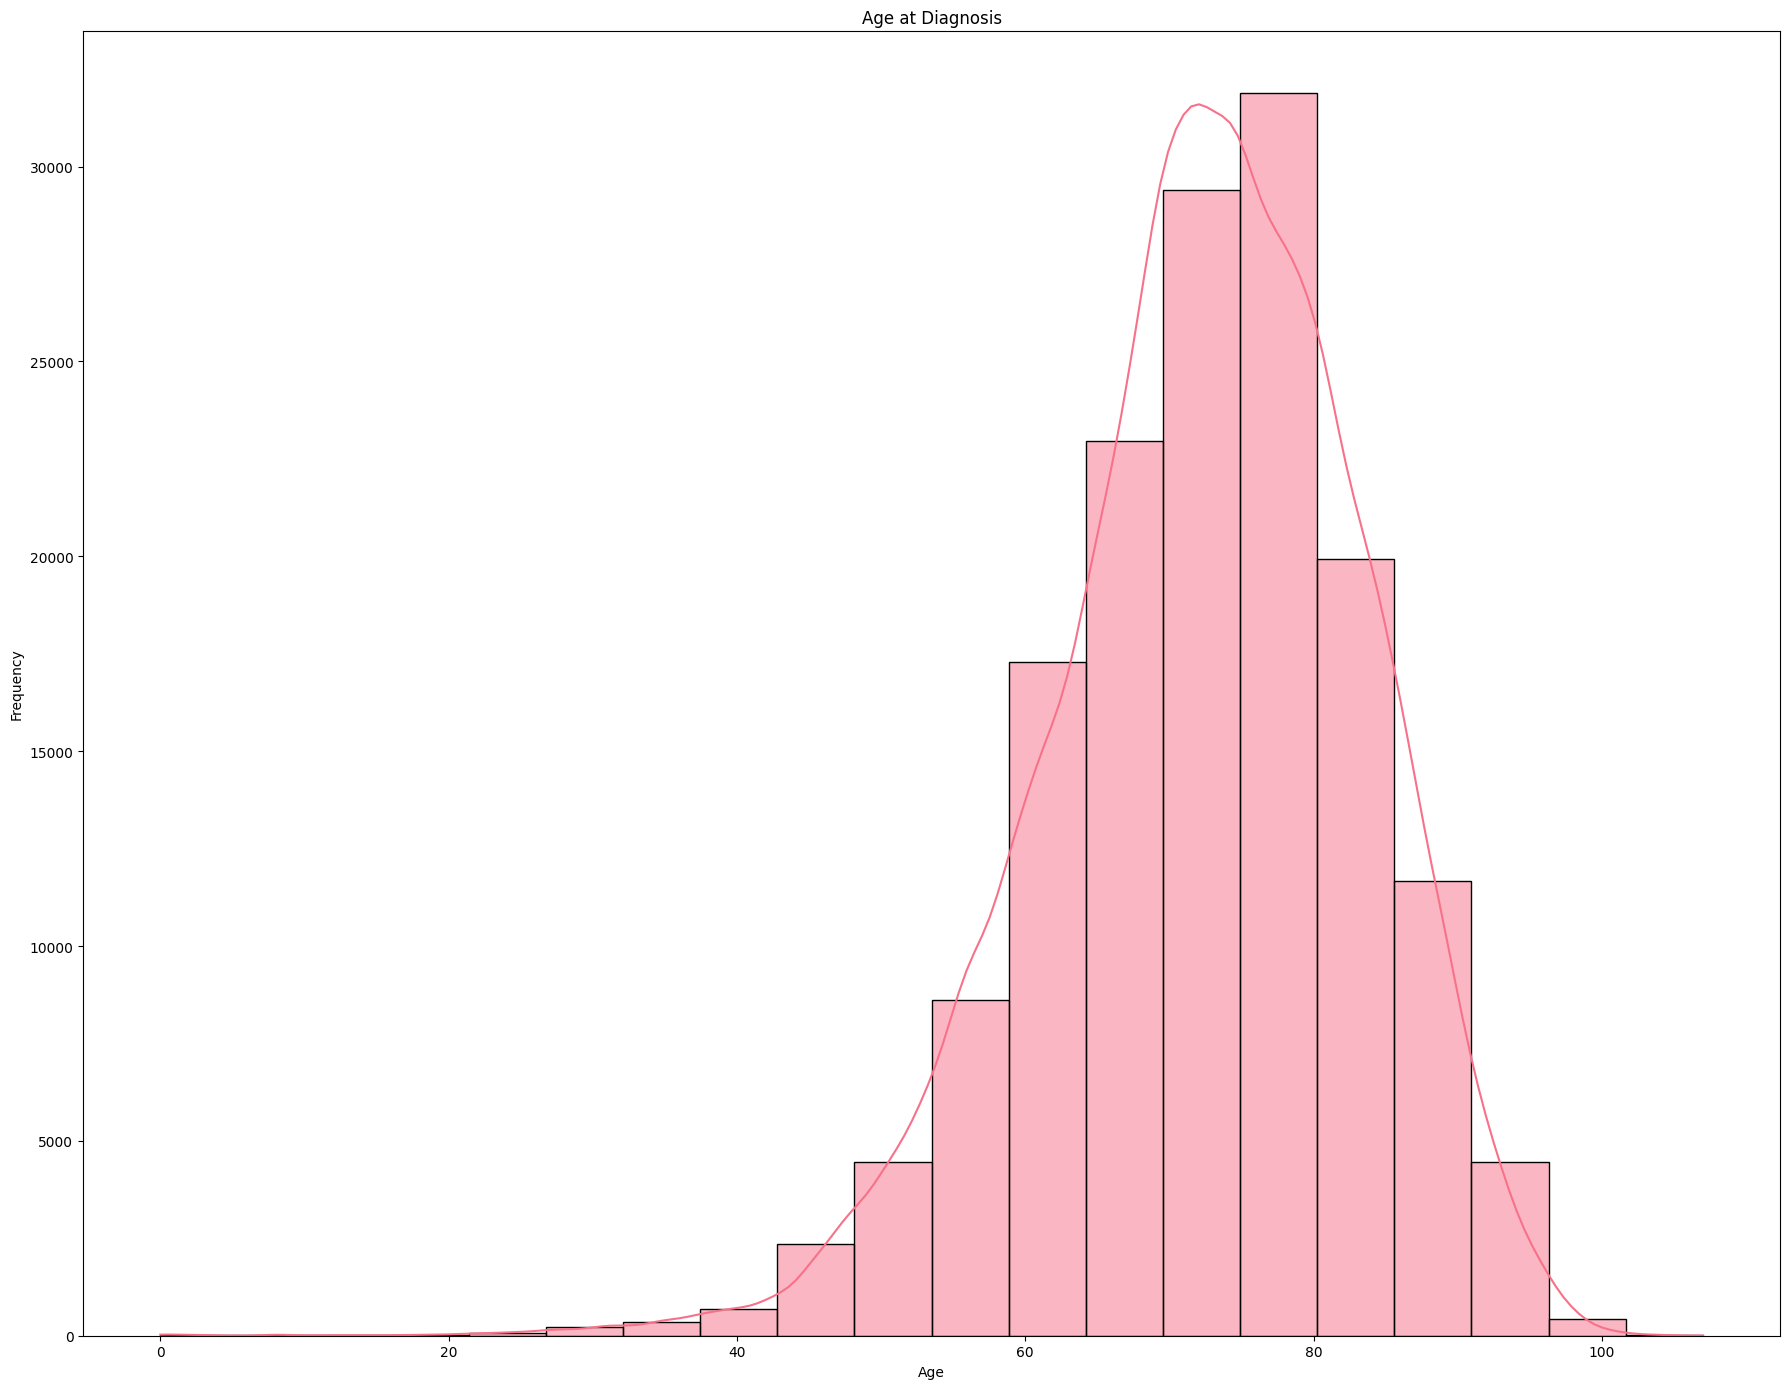

In [37]:
sns.histplot(df_lung["AGE"].dropna(), bins=20, kde=True)
plt.title("Age at Diagnosis")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

###  KAPLAN–MEIER

In [38]:
kmf = KaplanMeierFitter()

#### Overall

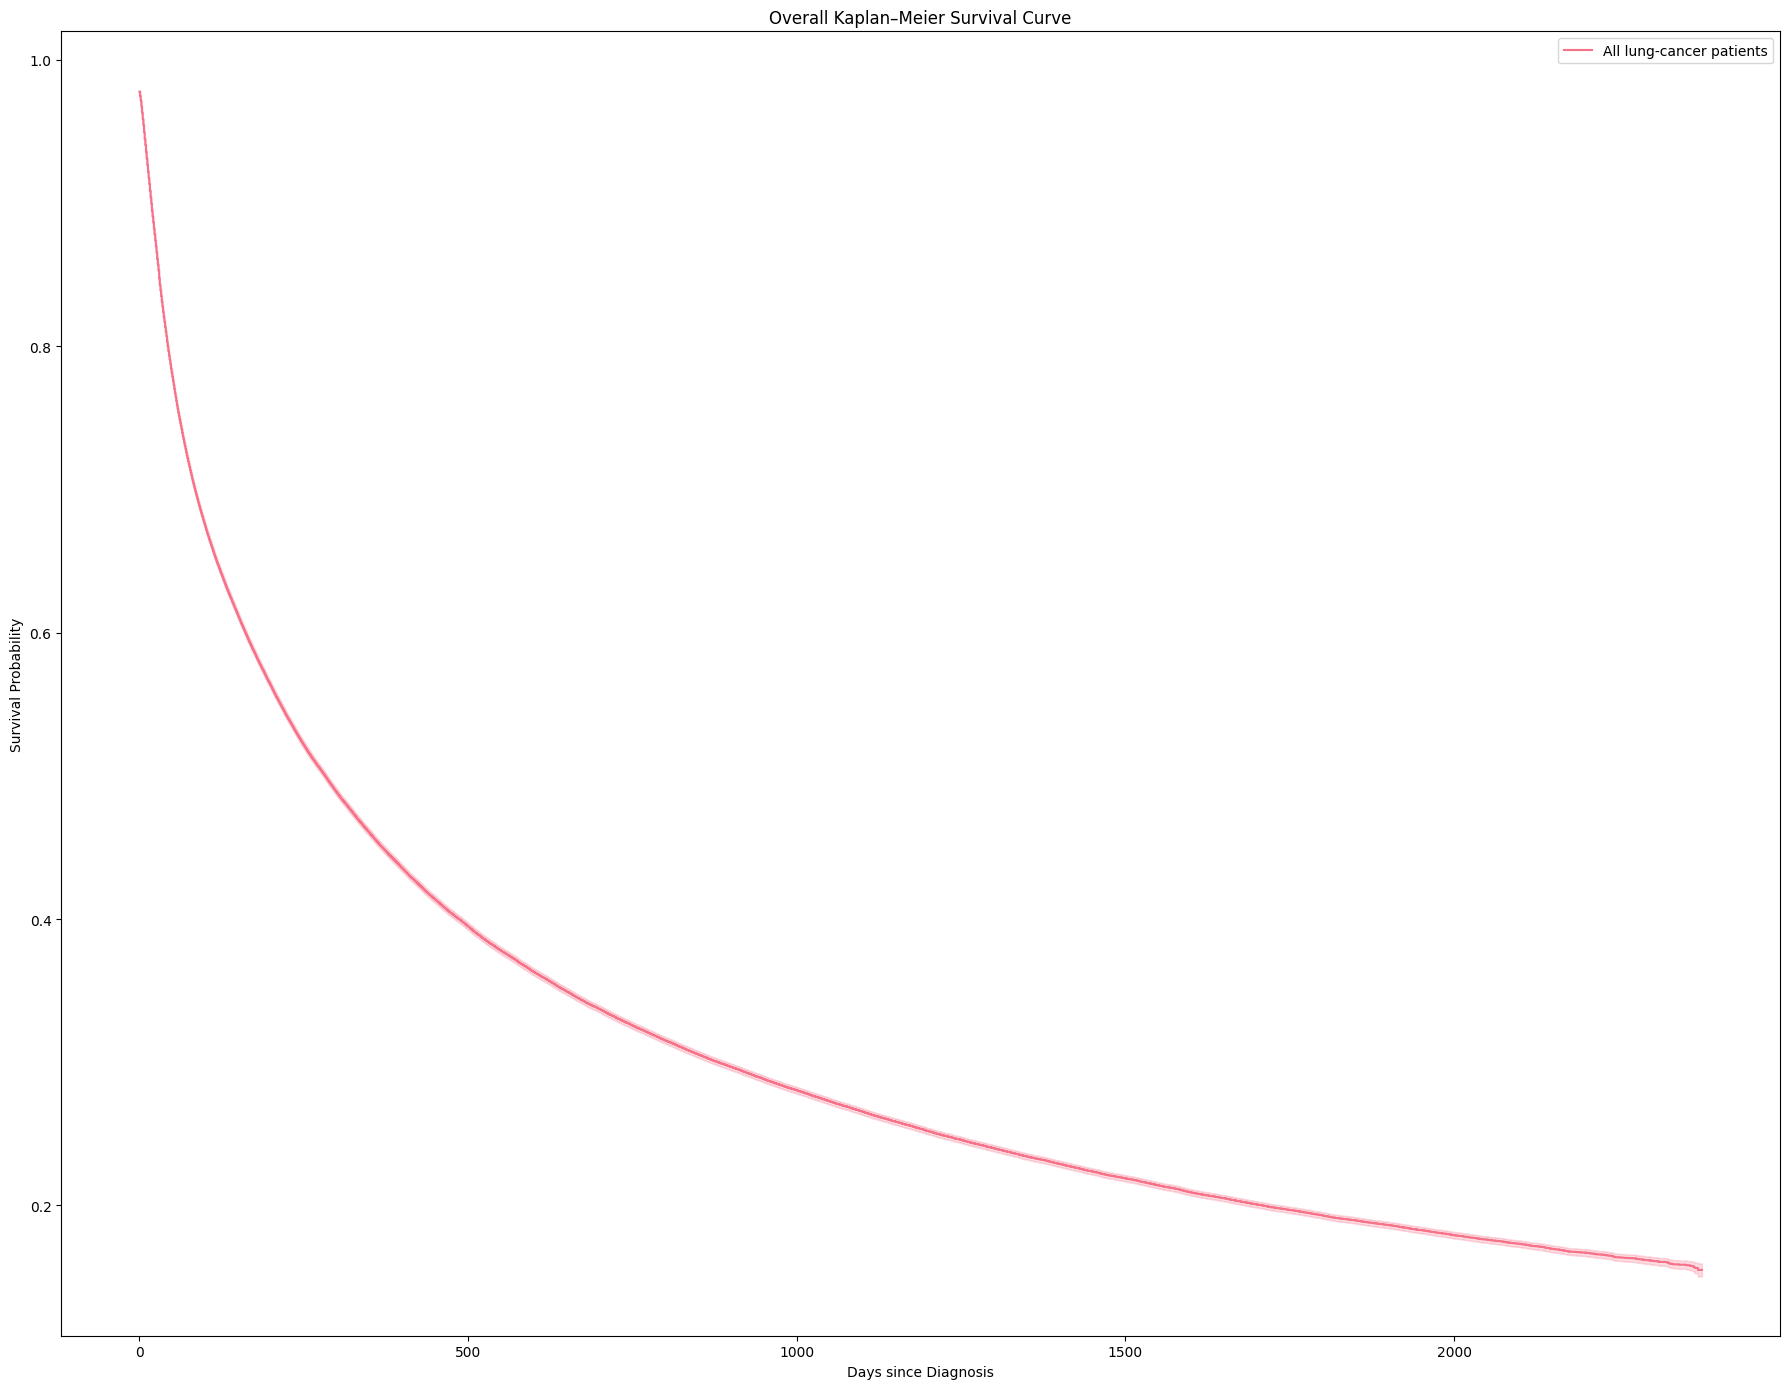

In [39]:
kmf.fit(df_surv['followup_days'], event_observed=df_surv['event_observed'],
        label="All lung-cancer patients")
kmf.plot_survival_function(ci_show=True)
plt.title("Overall Kaplan–Meier Survival Curve")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()

#### By Tumour Stage

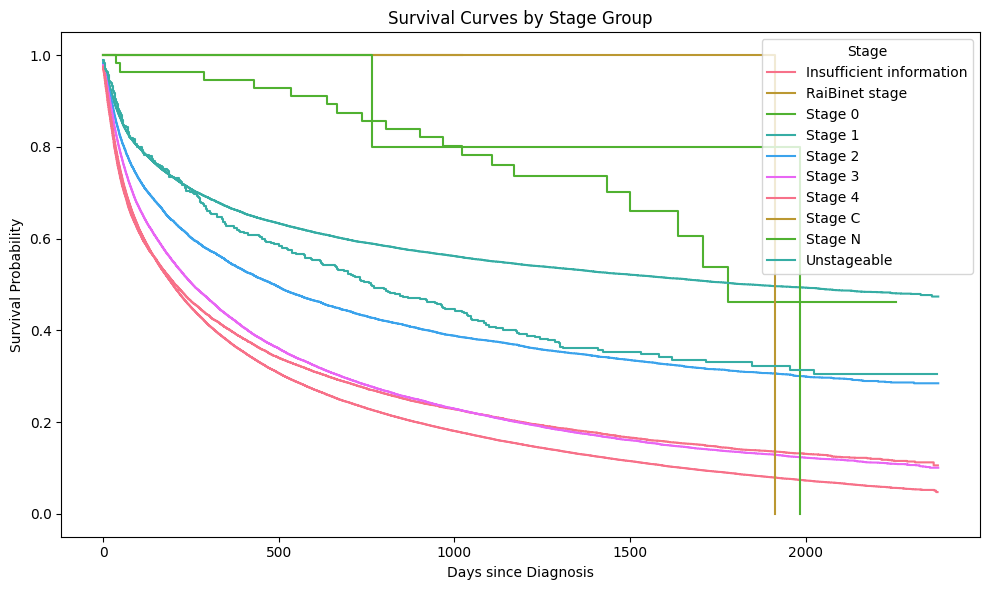

In [40]:
plt.figure(figsize=(10, 6))
for stage, grp in df_surv.dropna(subset=['Stage_Group']).groupby('Stage_Group'):
    kmf.fit(grp['followup_days'], grp['event_observed'], label=stage)
    kmf.plot_survival_function(ci_show=False)
plt.title("Survival Curves by Stage Group")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.legend(title="Stage")
plt.tight_layout()
plt.show()

### Stage & Genetic Testing Status

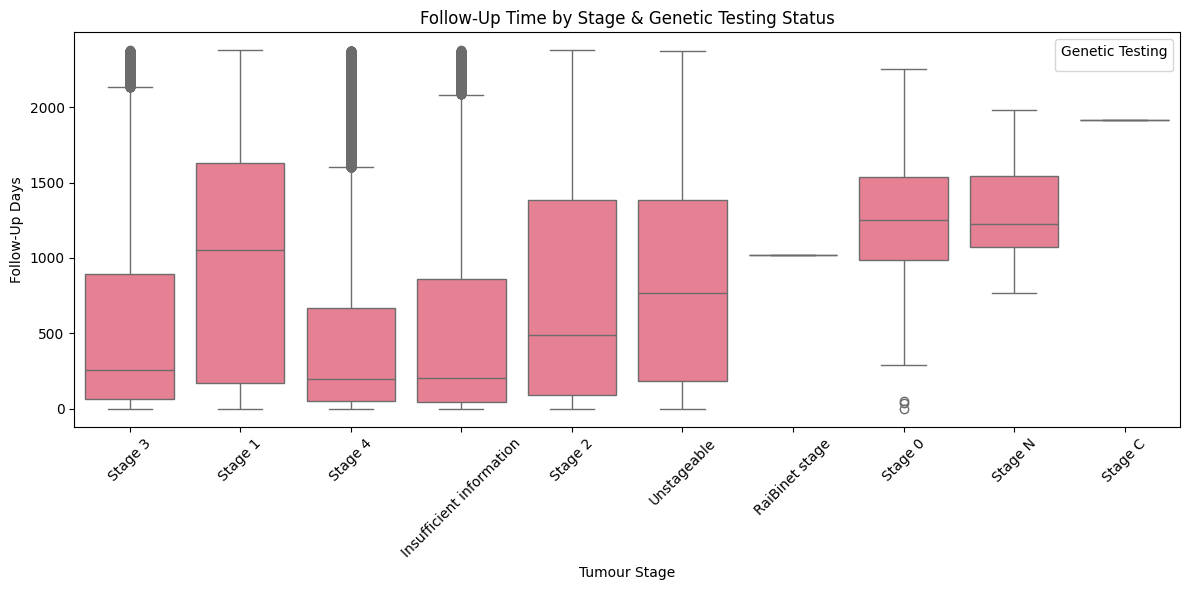

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_surv, x='Stage_Group', y='followup_days')
plt.title("Follow-Up Time by Stage & Genetic Testing Status")
plt.xlabel("Tumour Stage")
plt.ylabel("Follow-Up Days")
plt.xticks(rotation=45)
plt.legend(title="Genetic Testing")
plt.tight_layout()
plt.show()

### Radiotherapy Uptake

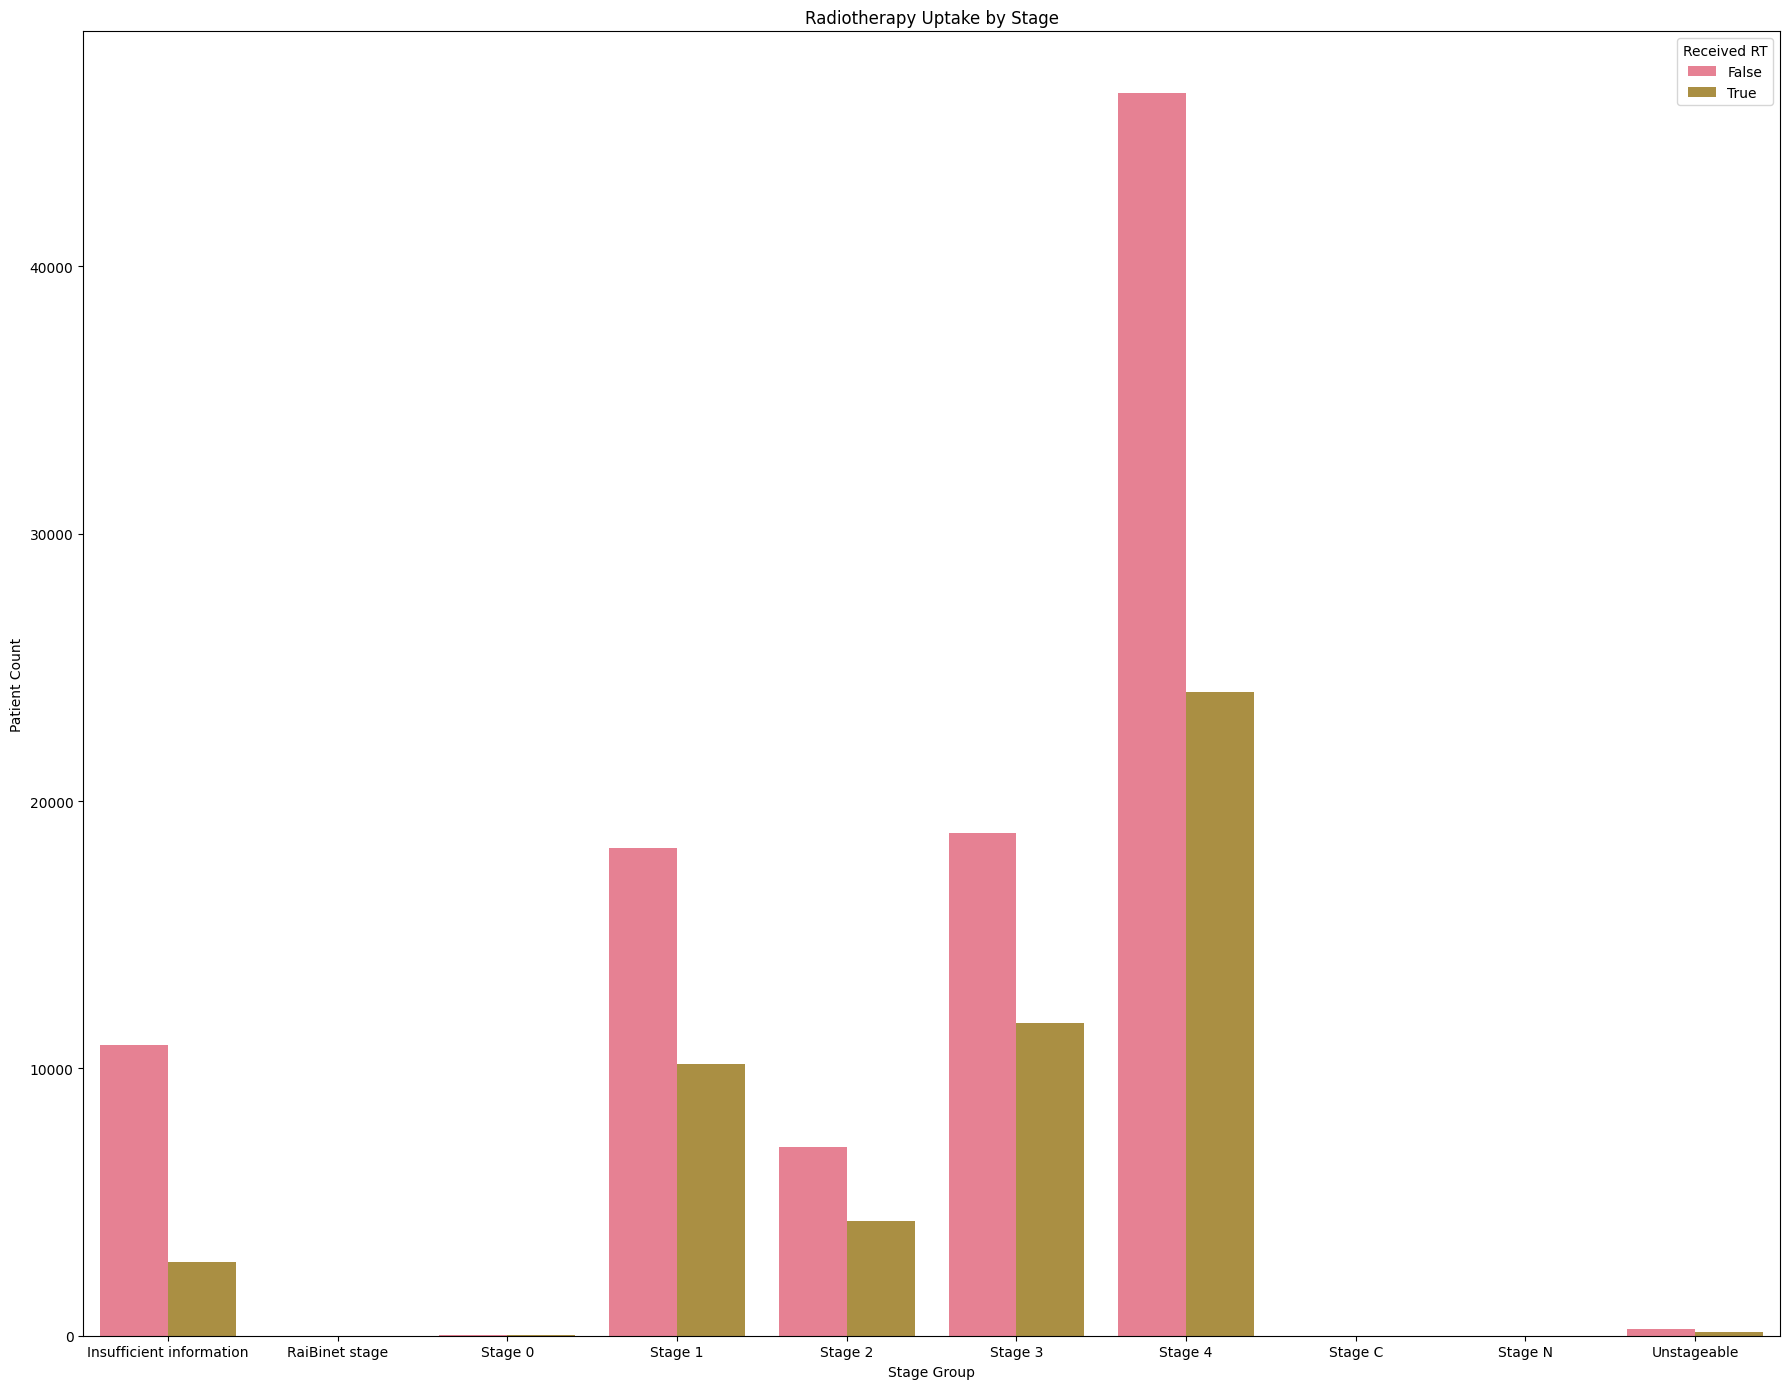

In [42]:
# 1.  Add human-readable intent label  (once only)
if 'rt_label' not in df_lung.columns:
    rt_intent_lookup = (
        pd.read_excel(LOOKUP_XLS, sheet_name="z_radiotherapyintent")
          .rename(columns={'Code': 'RADIOTHERAPYINTENT',
                           'Description': 'rt_label'})
    )
    df_lung = df_lung.merge(rt_intent_lookup,
                            on='RADIOTHERAPYINTENT',
                            how='left')

# 2.  Flag patients who received any radiotherapy row
df_lung['received_rt'] = df_lung['RADIOTHERAPYINTENT'].notna()

# 3-A.  Uptake by Stage (countplot)
sns.countplot(data=df_lung, x='Stage_Group', hue='received_rt',
              order=sorted(df_lung['Stage_Group'].unique()))
plt.title("Radiotherapy Uptake by Stage")
plt.xlabel("Stage Group")
plt.ylabel("Patient Count")
plt.legend(title="Received RT")
plt.tight_layout()
plt.show()

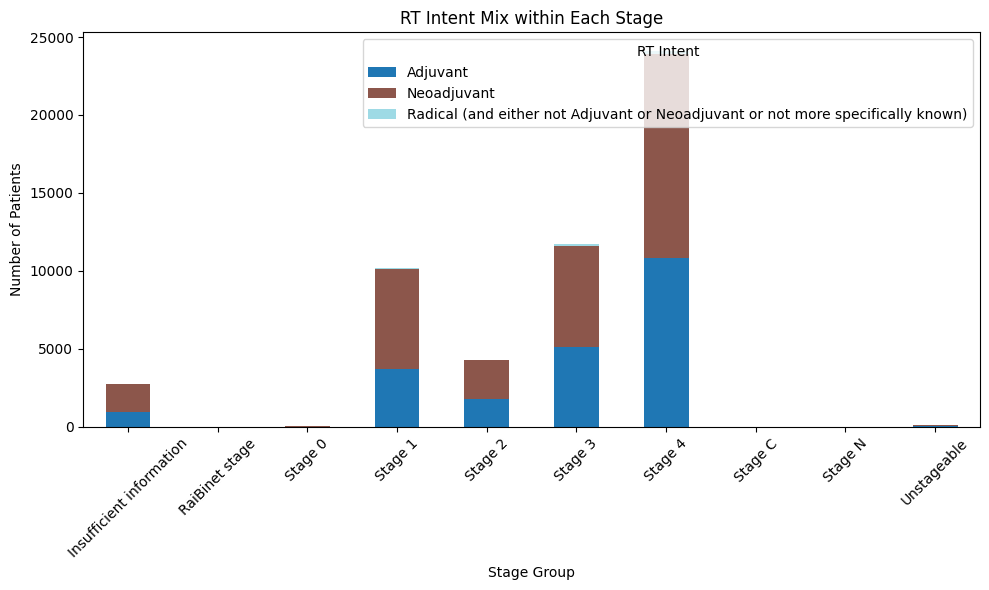

In [43]:
# 3-B.  Uptake by Intent type (stacked bar)
rt_counts = (df_lung[df_lung['received_rt']]
             .groupby(['Stage_Group', 'rt_label'])
             .size()
             .unstack(fill_value=0)
             .reindex(sorted(df_lung['Stage_Group'].unique())))
rt_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("RT Intent Mix within Each Stage")
plt.xlabel("Stage Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.legend(title="RT Intent")
plt.tight_layout()
plt.show()


### Systemic Anti-Cancer Therapy (SACT) Uptake

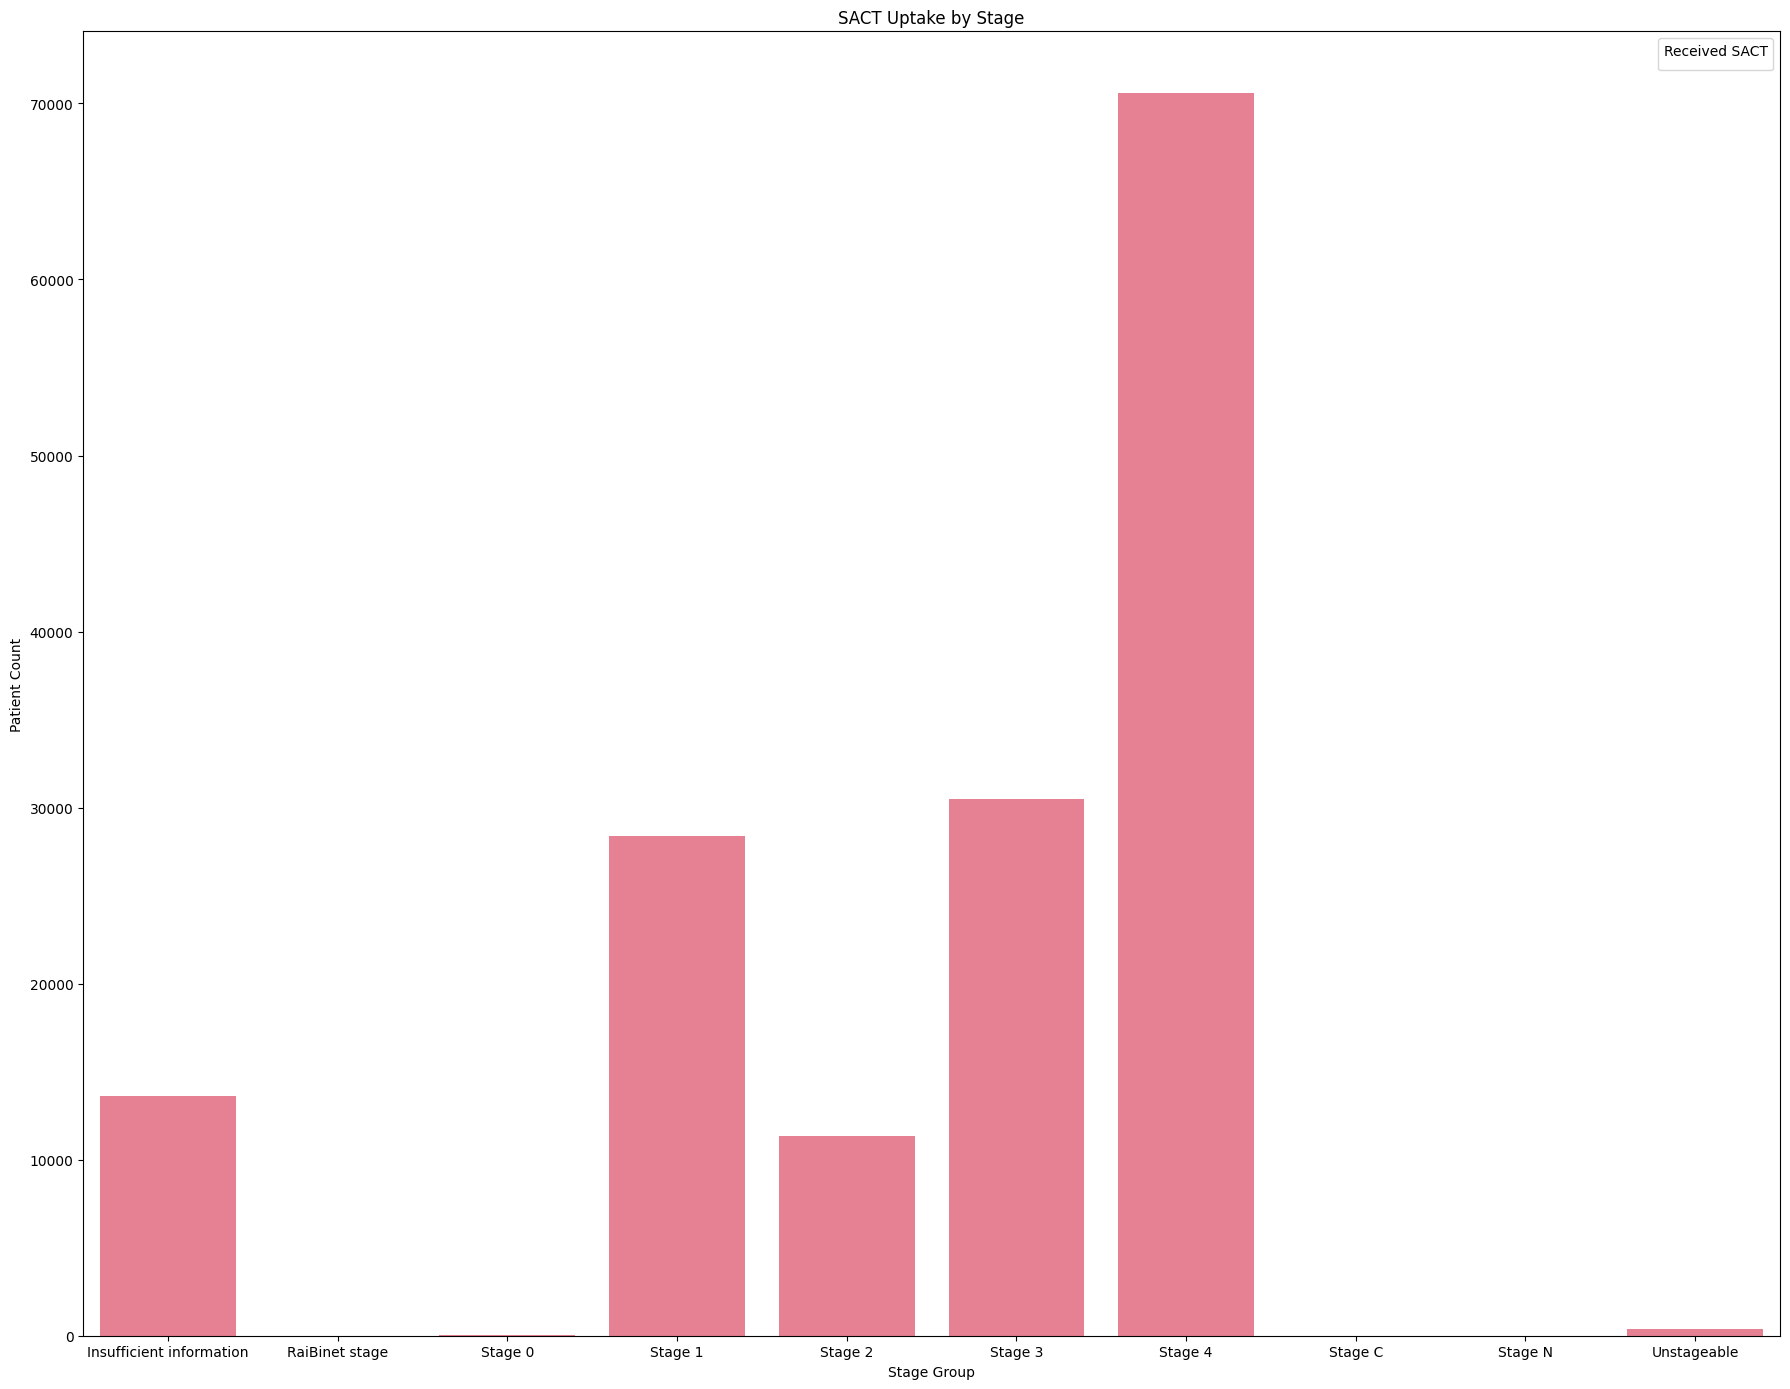

In [44]:
sns.countplot(
    data=df_lung,
    x='Stage_Group',
    # hue='received_sact',
    order=sorted(df_lung['Stage_Group'].unique())
)
plt.title("SACT Uptake by Stage")
plt.xlabel("Stage Group")
plt.ylabel("Patient Count")
plt.legend(title="Received SACT")
plt.tight_layout()
plt.show()

### Gene Testing Analysis

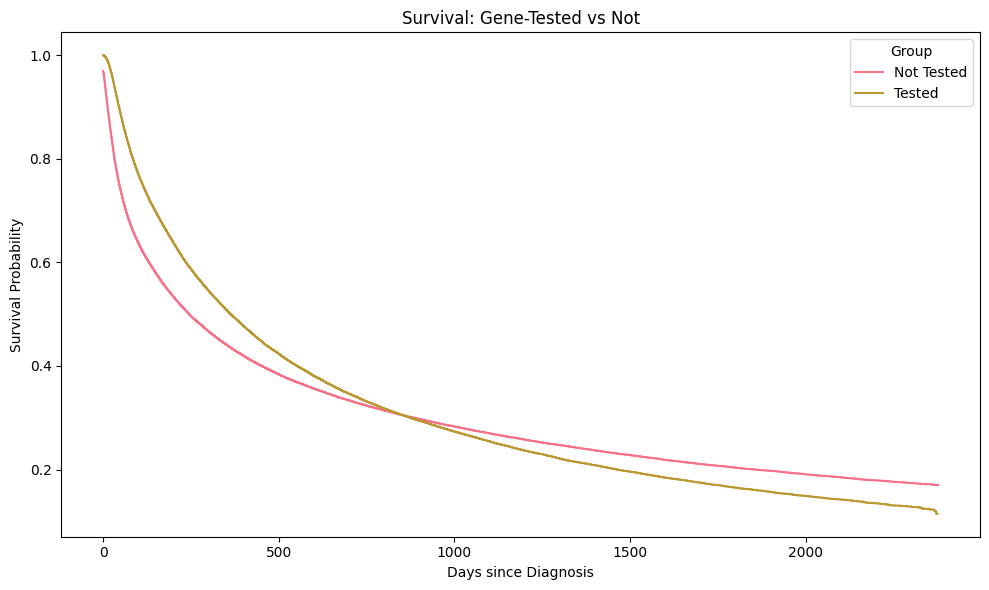

In [45]:
df_surv['tested_group'] = np.where(df_surv['num_genes_tested'] > 0,
                                   'Tested', 'Not Tested')

plt.figure(figsize=(10, 6))
for lbl, grp in df_surv.groupby('tested_group'):
    kmf.fit(grp['followup_days'], grp['event_observed'], label=lbl)
    kmf.plot_survival_function(ci_show=False)
plt.title("Survival: Gene-Tested vs Not")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.legend(title="Group")
plt.tight_layout()
plt.show()

### Death Rate by Stage

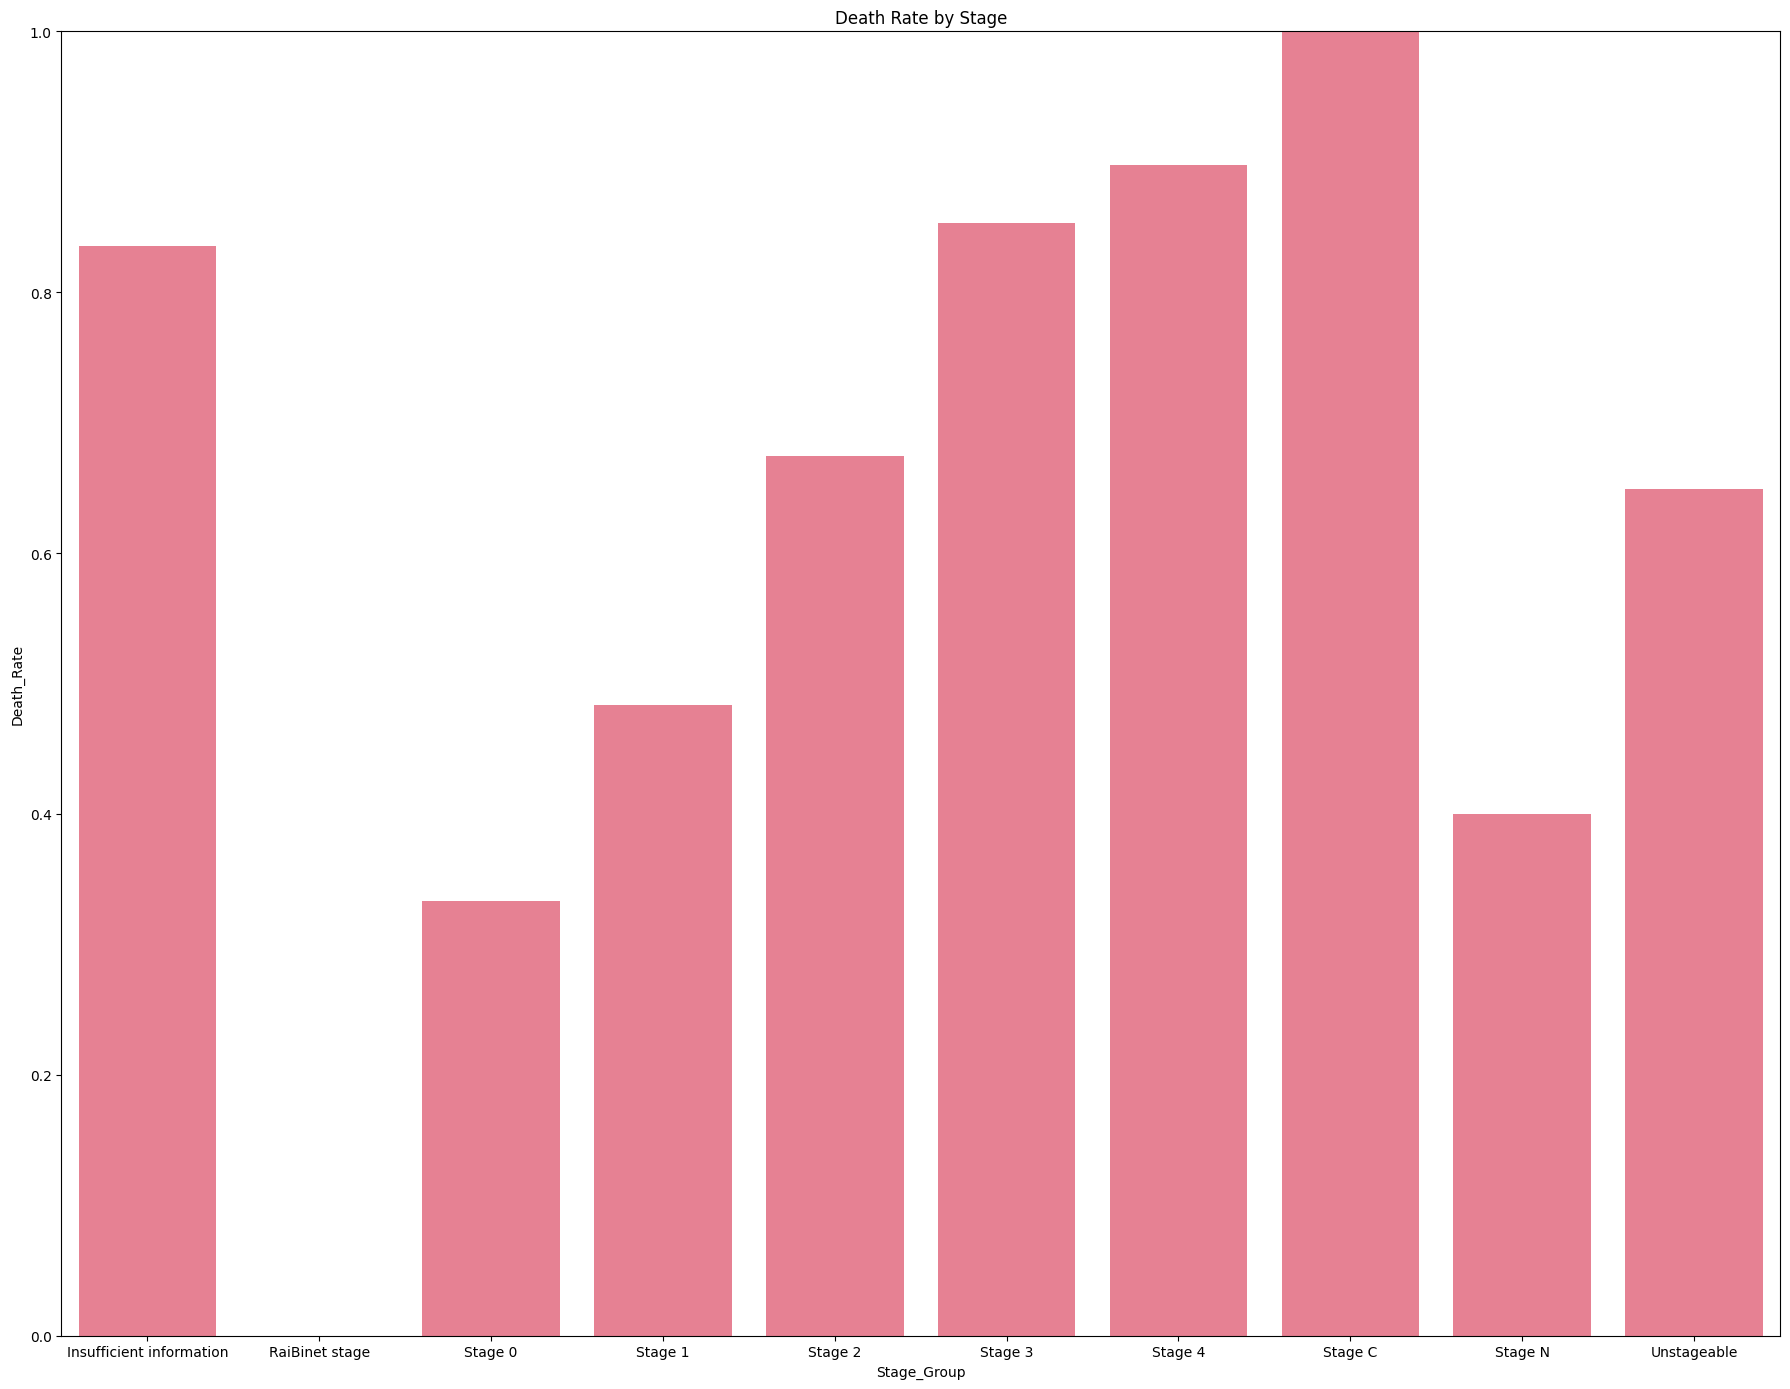

In [46]:
death_rate = (df_surv.groupby('Stage_Group')['event_observed']
                    .mean().reset_index()
                    .rename(columns={'event_observed':'Death_Rate'}))

sns.barplot(data=death_rate, x='Stage_Group', y='Death_Rate',
            order=death_rate['Stage_Group'])
plt.title("Death Rate by Stage")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Follow-up Time Distribution by Stage & Event Status

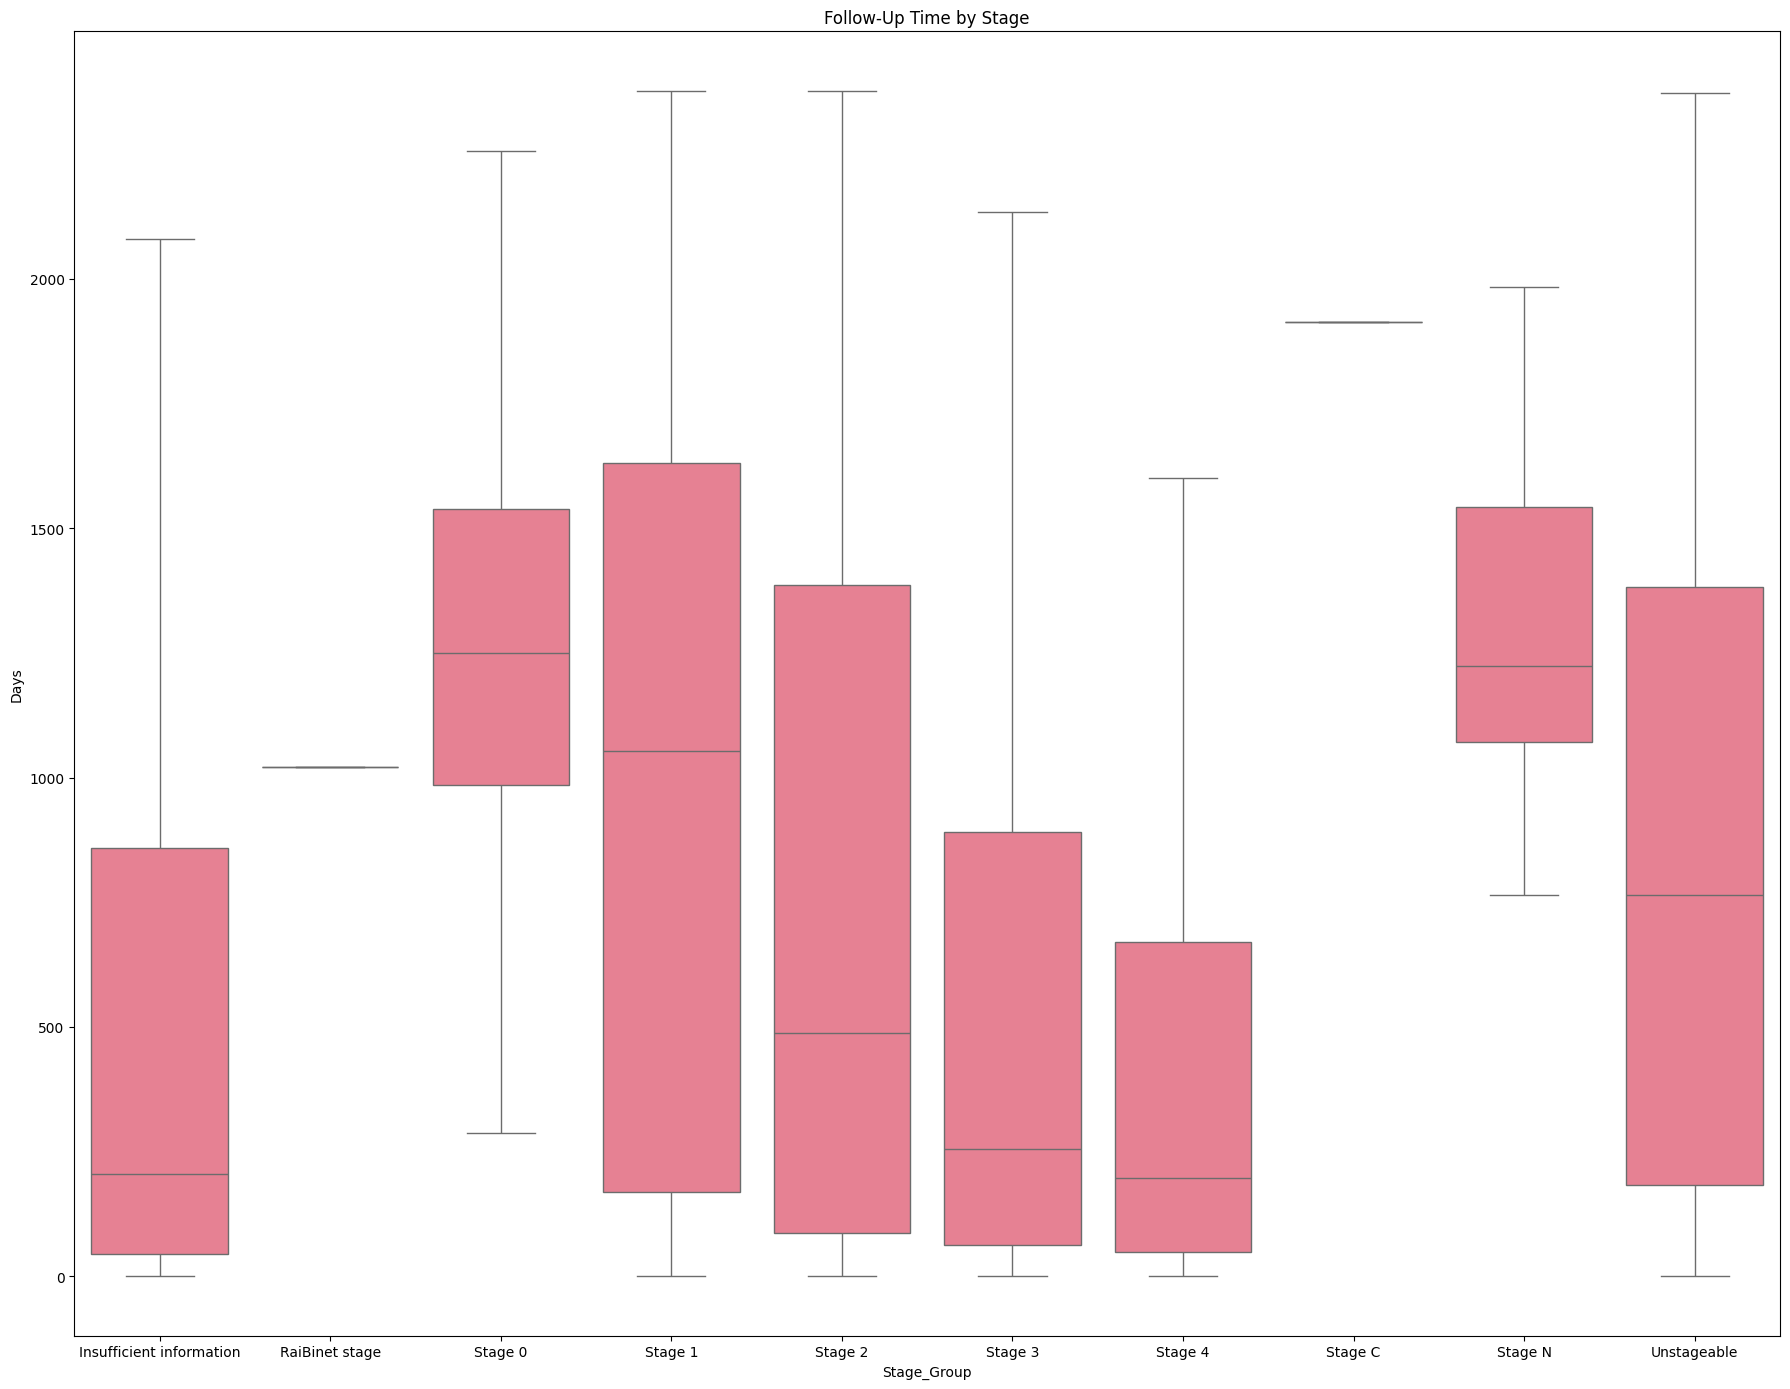

In [47]:
# Boxplot of follow-up days by Stage_Group
sns.boxplot(data=df_surv, x='Stage_Group', y='followup_days',
            showfliers=False, order=sorted(df_surv['Stage_Group'].unique()))
plt.title("Follow-Up Time by Stage")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

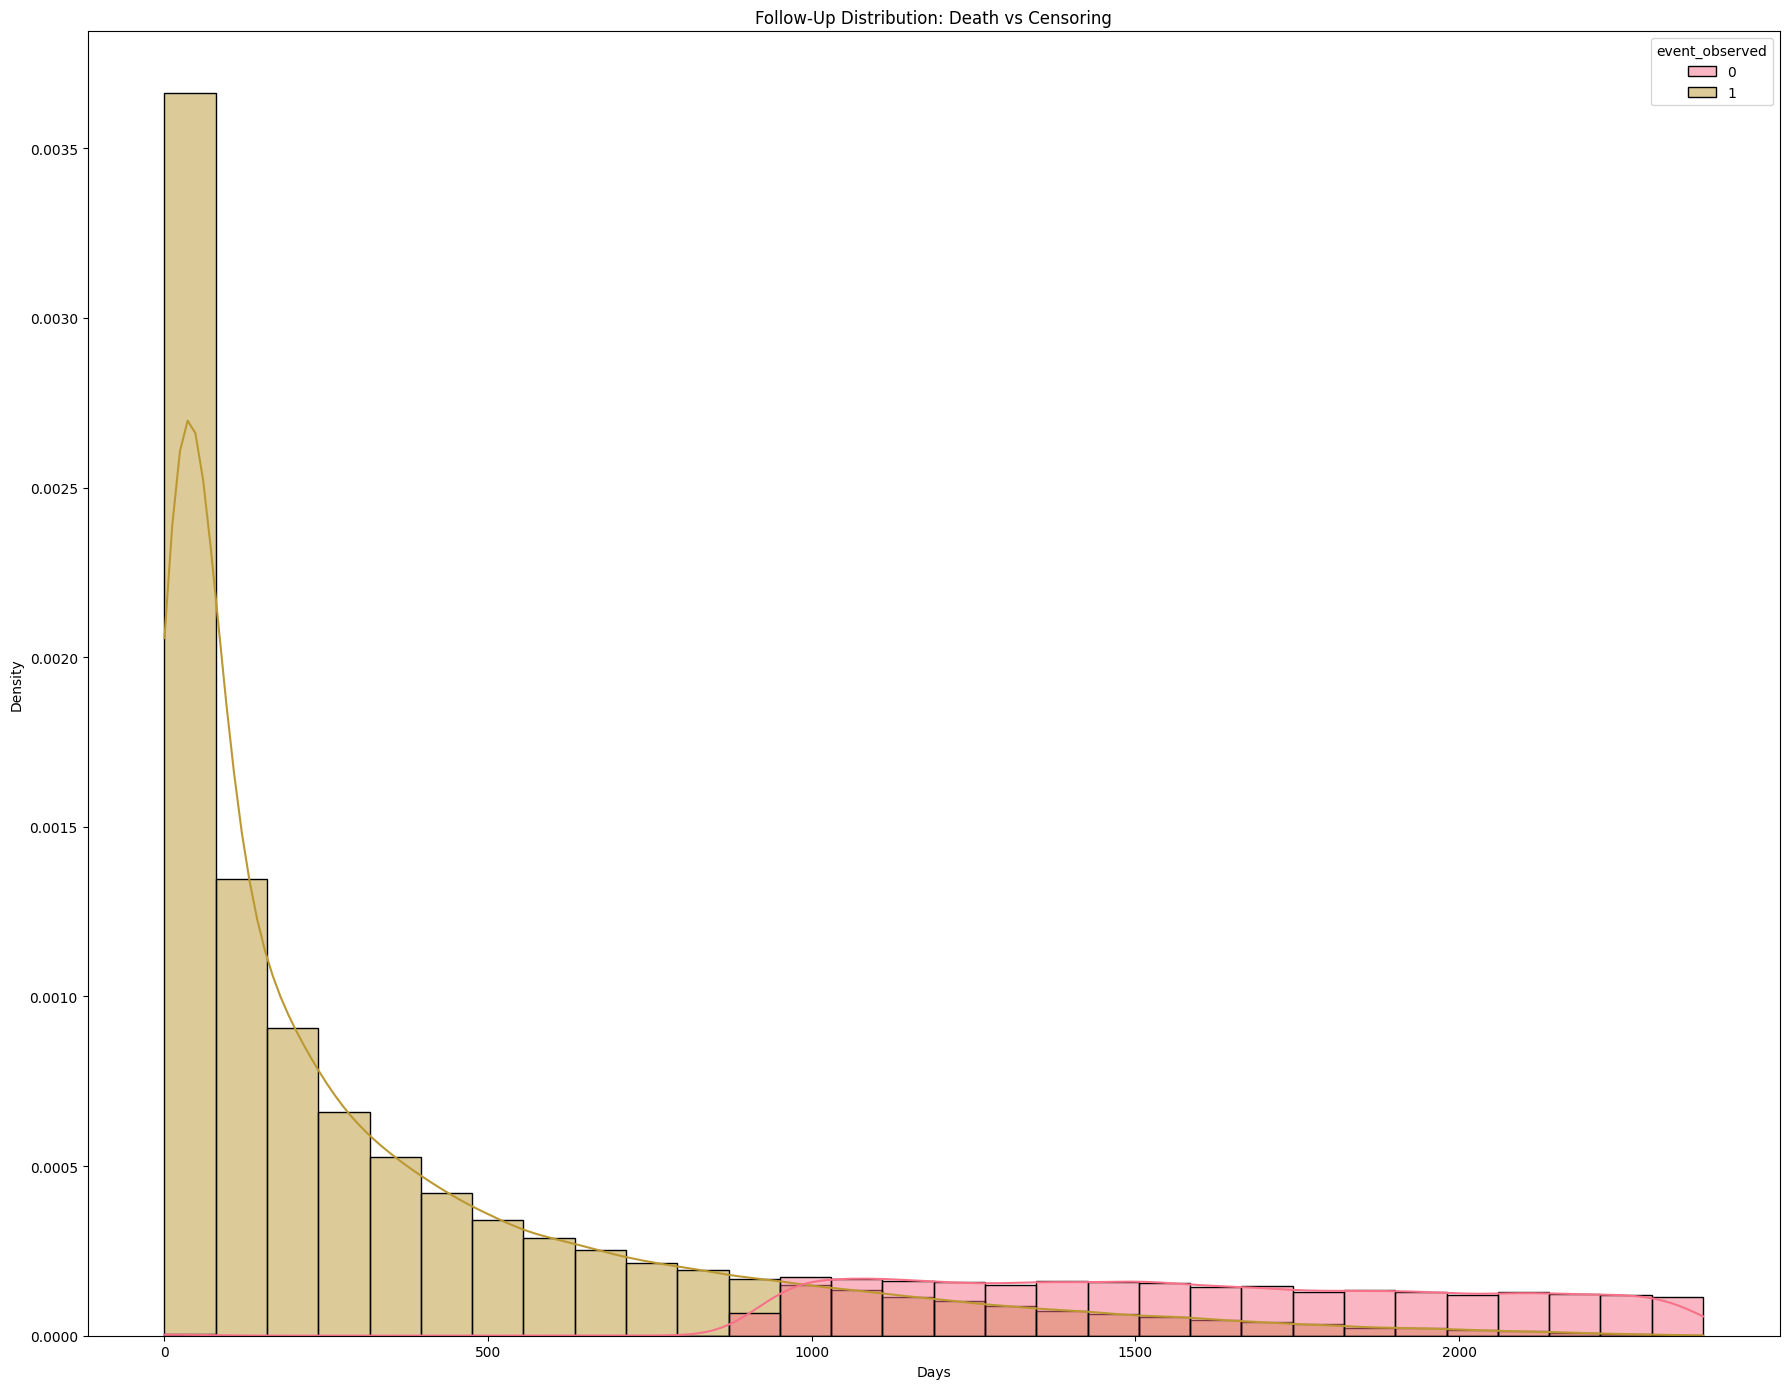

In [48]:
sns.histplot(data=df_surv, x='followup_days', hue='event_observed',
             bins=30, kde=True, stat="density")
plt.title("Follow-Up Distribution: Death vs Censoring")
plt.xlabel("Days")
plt.tight_layout()
plt.show()

### Stacked Bar Chart: Survival Outcome by Ethnicity

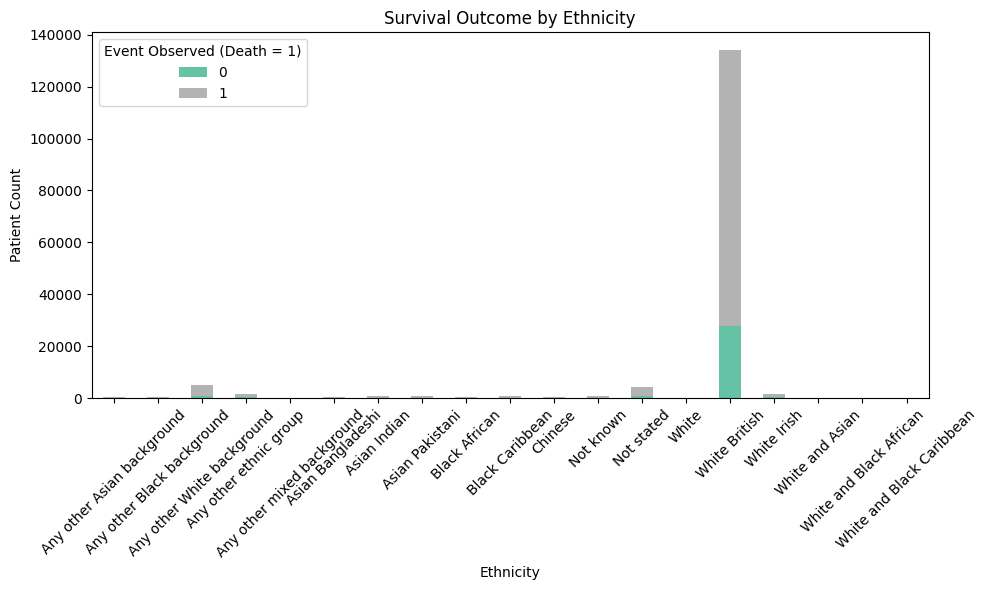

In [49]:
eth_counts = (df_lung
              .loc[:, ['ethnicity_label', 'event_observed']]
              .groupby(['ethnicity_label', 'event_observed'])
              .size()
              .unstack(fill_value=0)
              .sort_index())

eth_counts.plot(kind='bar',
                stacked=True,
                colormap='Set2',
                figsize=(10, 6))

plt.title("Survival Outcome by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Patient Count")
plt.xticks(rotation=45)
plt.legend(title="Event Observed (Death = 1)")
plt.tight_layout()
plt.show()


### SACT Uptake by Gender

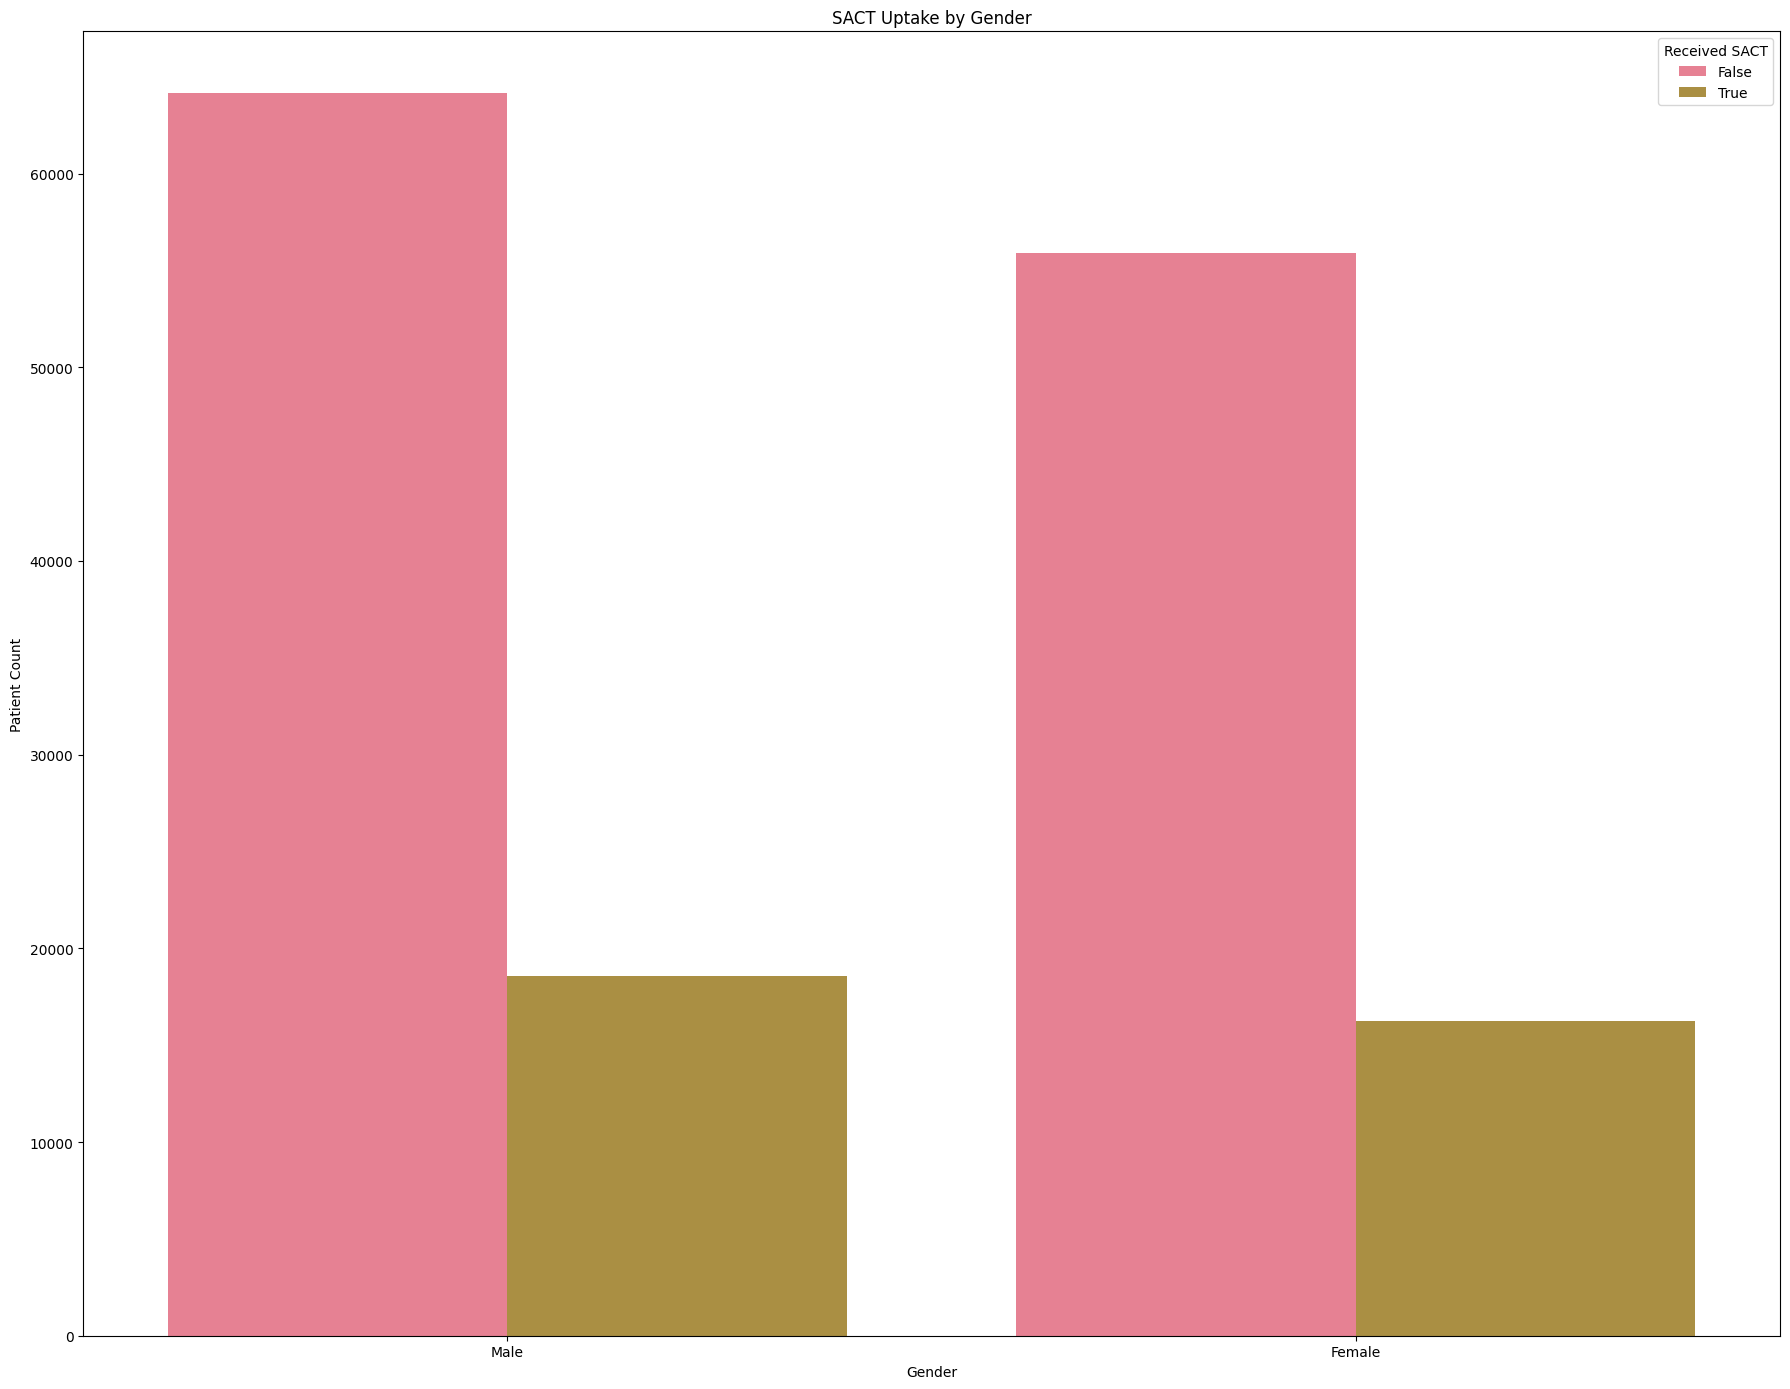

In [50]:
sns.countplot(data=df_lung,
              x='gender_label',
              hue='received_sact')
plt.title("SACT Uptake by Gender")
plt.xlabel("Gender")
plt.ylabel("Patient Count")
plt.legend(title="Received SACT")
plt.tight_layout()
plt.show()

### Kaplan–Meier Survival Curve

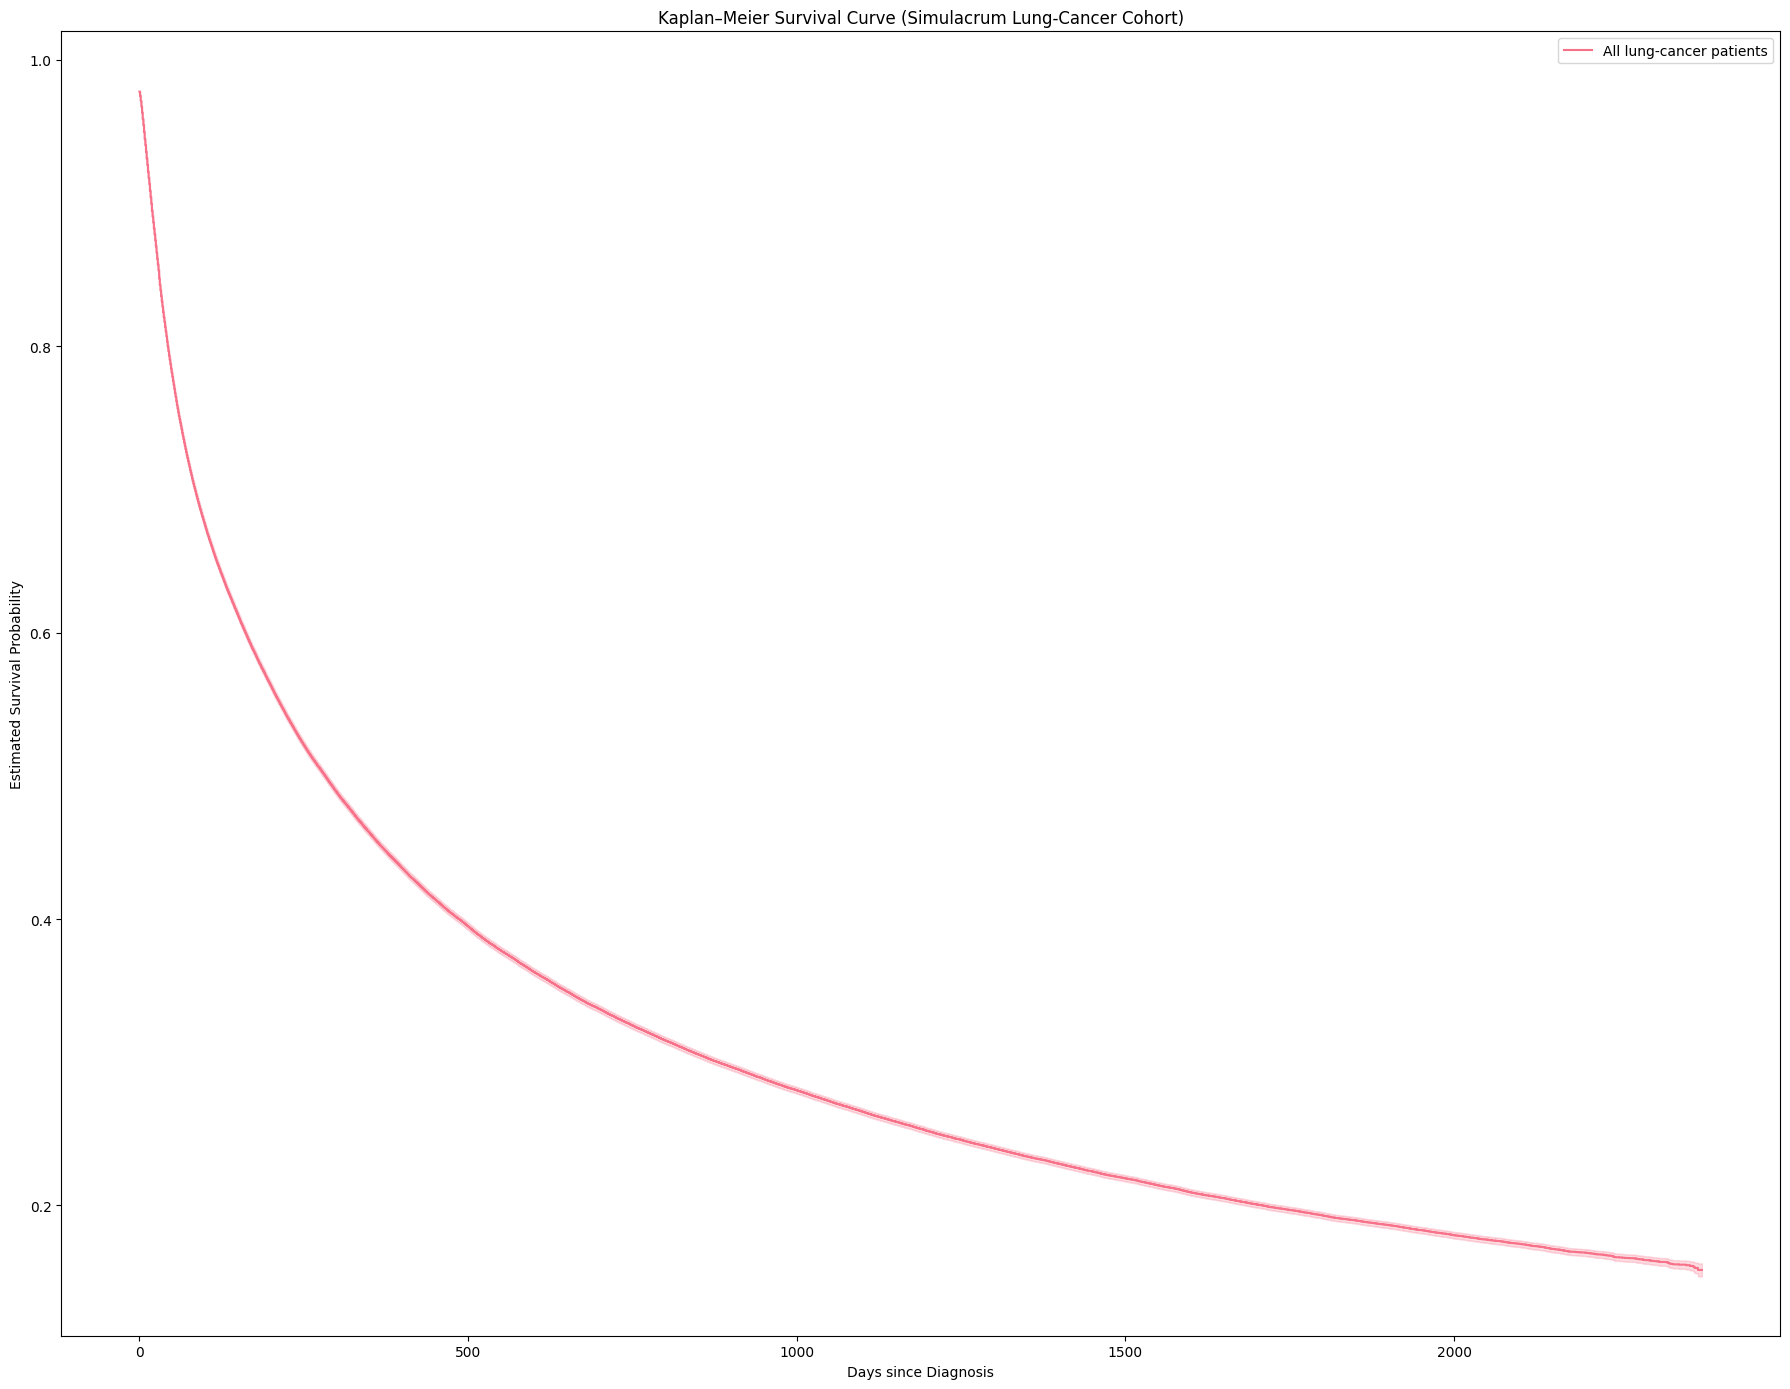

In [51]:
# Keep only rows with a valid follow-up time ≥ 0
df_surv = df_lung[df_lung['followup_days'].notna() & (df_lung['followup_days'] >= 0)]


kmf.fit(
    durations=df_surv['followup_days'],
    event_observed=df_surv['event_observed'],
    label="All lung-cancer patients"
)

kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curve (Simulacrum Lung-Cancer Cohort)")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Estimated Survival Probability")
plt.tight_layout()
plt.show()

# Version TC C34

In [52]:
GROUP_8_PATH = '/content/drive/My Drive/Group8_TC_C34_v2_Data'

In [53]:
df_sim_av_patient = pd.read_csv(GROUP_8_PATH+'/sim_av_patient_c34.csv')

In [54]:
df_sim_av_patient.head()

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,LINKNUMBER
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101115525
1,10175273,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101155391
2,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101574796
3,10175292,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,100834633
4,10175333,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,100951264


In [55]:
df_sim_av_gene = pd.read_csv(GROUP_8_PATH+'/sim_av_gene_c34.csv')

In [56]:
df_sim_av_gene.head()

,GENEID,TUMOURID,PATIENTID,GENE_DESC,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,ALL_TESTSTATUSES,OVERALL_TS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10037483,11641162,10243109,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-01-22,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,10037484,11723811,10243117,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-03-25,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,10037492,11502311,10243418,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-26,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,10037495,10073014,10243465,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-05-15,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,10037528,10014582,10244392,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-12,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [57]:
df_sim_av_gene.describe()

,GENEID,TUMOURID,PATIENTID,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,NO_OF_AB_GATS,NO_OF_SEQ_VARS,NO_OF_PRO_IMPS
count,1.006890e+05,1.006890e+05,1.006890e+05,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000
mean,1.006210e+08,1.100121e+07,1.005732e+08,1503.639126,1.092562,1.228913,1.058974,0.149947,0.034443,0.039567
std,1.189183e+07,5.785224e+05,1.189137e+07,2210.732603,0.424913,0.594973,0.333099,0.358188,0.202885,0.235377
min,1.003748e+07,1.000012e+07,1.017521e+07,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000248e+08,1.049507e+07,1.000084e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000618e+08,1.100333e+07,1.000194e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.001025e+08,1.150246e+07,1.000291e+08,4842.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.500091e+08,1.199998e+07,2.500025e+08,5037.000000,23.000000,23.000000,23.000000,2.000000,4.000000,5.000000


In [58]:
df_patient_gene = pd.merge(df_sim_av_patient, df_sim_av_gene, on='PATIENTID', how='left')

In [59]:
df_patient_gene

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,2019-11-09,1)authoriseddate,NaN,NaN,NaN,0.0,NaN,NaN,Bristol (molecular lab)
1,10175273,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,2017-08-07,1)authoriseddate,NaN,NaN,NaN,0.0,NaN,NaN,Newcastle (molecular lab)
3,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,2017-09-16,1)authoriseddate,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,10175292,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214784,250002505,2,A,C445,NaN,NaN,NaN,C809,1,D,...,NaN,2019-12-26,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
214785,250002507,2,A,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214786,250002519,2,J,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214787,250002530,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Check the result
print(f"Original patient records: {len(df_sim_av_patient)}")
print(f"Original gene records: {len(df_sim_av_gene)}")
print(f"Combined records: {len(df_patient_gene)}")
print(f"Combined columns: {len(df_patient_gene.columns)}")

Original patient records: 157354
Original gene records: 100689
Combined records: 214789
Combined columns: 40


In [61]:
print(df_patient_gene.columns)

Index(['PATIENTID', 'GENDER', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
       'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS',
       'VITALSTATUSDATE', 'LINKNUMBER', 'GENEID', 'TUMOURID', 'GENE_DESC',
       'GENE', 'COUNT_TESTS', 'COUNT_RESULTS', 'COUNT_DATE',
       'ALL_TESTSTATUSES', 'OVERALL_TS', 'NO_OF_AB_GATS', 'DNASEQ_GAT',
       'METHYL_GAT', 'EXP_GAT', 'COPYNO_GAT', 'FUS_TRANS_GAT', 'ABNORMAL_GAT',
       'NO_OF_SEQ_VARS', 'ALL_SEQ_VARS', 'SEQ_VAR', 'DATE_OVERALL_TS',
       'BEST_DATE_SOURCE_OVERALL_TS', 'MIN_DATE', 'MAX_DATE', 'ALL_PRO_IMPS',
       'NO_OF_PRO_IMPS', 'PRO_IMP', 'METHODS', 'LAB_NAME'],
      dtype='object')
